In [1]:
import os
import sys
import time
import pickle
import string
from datetime import datetime
from datetime import timedelta
from itertools import chain, cycle
import collections
from pprint import pprint
from io import StringIO
import pathlib
import sqlite3

import numpy as np
import pandas as pd
import dask.dataframe as dd
from pandas.tools.plotting import parallel_coordinates
import matplotlib.pyplot as plt

#import urllib
#import webbrowser
#import codecs
from bs4 import BeautifulSoup
from xml.dom import minidom
from xml.etree import ElementTree as ET
#from lxml import etree as ET #Supports xpath syntax
import xmltodict 

import nltk
import re
import Levenshtein
import networkx as nx
import json

#from nominatim import Nominatim
#from mpl_toolkits.basemap import Basemap   #http://matplotlib.org/basemap/api/basemap_api.html
from matplotlib import cm
import geopy.geocoders as gg
from geopy.geocoders import Nominatim
import geopandas as gpd
import ipyleaflet
#from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl, WMSLayer, Marker, MarkerCluster

import folium
import folium.plugins
#from folium.plugins import MarkerCluster
#from folium.plugins import FastMarkerCluster


#import plotly as py
#import plotly.graph_objs as go
#import plotly.figure_factory as ff

from IPython.display import Image, HTML, IFrame, FileLink, FileLinks #needed to render in notebook
from IPython.core.display import display

In [2]:
df_lemmas = pd.read_pickle('./df_lemmas.pkl')

In [3]:
df_lemmas.info(verbose=True, null_counts=True, memory_usage='deep') #, max_cols=100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416499 entries, 0 to 2416498
Data columns (total 52 columns):
Bundesland               1316889 non-null object
Bundesland_idno          1316889 non-null object
Gemeinde                 1198447 non-null object
Großregion               1296722 non-null object
Großregion_idno          1225463 non-null object
Kleinregion              1286463 non-null object
Kleinregion_idno         1209145 non-null object
Ort                      1198447 non-null object
Ort_idno                 1198447 non-null object
archiv                   2416419 non-null object
bibl                     1719656 non-null object
certainty                25631 non-null object
cit_def                  461023 non-null object
cit_interp               353677 non-null object
cit_note                 111690 non-null object
cit_pRef                 79913 non-null object
cit_quote                704560 non-null object
cit_re                   113327 non-null object
cit_ref       

In [4]:
df_lemmas.columns

Index(['Bundesland', 'Bundesland_idno', 'Gemeinde', 'Großregion',
       'Großregion_idno', 'Kleinregion', 'Kleinregion_idno', 'Ort', 'Ort_idno',
       'archiv', 'bibl', 'certainty', 'cit_def', 'cit_interp', 'cit_note',
       'cit_pRef', 'cit_quote', 'cit_re', 'cit_ref', 'cit_type', 'date',
       'entry_id', 'etym', 'filename', 'fragebogenNummer',
       'hauptlemma_normalized', 'hauptlemma_orig', 'hauptlemma_unique',
       'nebenlemma_normalized', 'nebenlemma_orig', 'nebenlemma_unique',
       'note_anmerkung', 'note_diverse', 'note_notabene', 'orig_placeName',
       'paragraph', 'placeName_id', 'pos', 'quelle', 'quelleBearbeitet',
       'seite', 'simple_placeName', 'tustep', 'usg_corresp', 'verweise',
       '#form', '#drawer', '#fragebogen', '#bestlemma', '#typist',
       '_coordinates', '_location'],
      dtype='object')

In [5]:
df_lemmas.head()

,Bundesland,Bundesland_idno,Gemeinde,Großregion,Großregion_idno,Kleinregion,Kleinregion_idno,Ort,Ort_idno,archiv,...,tustep,usg_corresp,verweise,#form,#drawer,#fragebogen,#bestlemma,#typist,_coordinates,_location
0,None,None,None,None,None,None,None,None,None,"HK 154, d154^#1.1 = d1540308.pir^#1.1",...,"(diaun,)",None,None,HK 154,HK 154,None,Diaun,Barbara Piringer,None,None
1,None,None,None,None,None,None,None,None,None,"HK 154, d154^#2.1 = d1540308.pir^#2.1",...,"(diaun,)",None,None,HK 154,HK 154,None,Diaun,Barbara Piringer,None,None
2,None,None,None,None,None,None,None,None,None,"HK 154, d154^#3.1 = d1540308.pir^#3.1",...,"(diaun,)",None,None,HK 154,HK 154,None,Diaun,Barbara Piringer,None,None
3,None,None,None,None,None,None,None,None,None,"HK 154, d154^#4.1 = d1540308.pir^#4.1",...,"(tib,)",None,None,HK 154,HK 154,Systematic,tib,Barbara Piringer,None,None
4,None,None,None,None,None,None,None,None,None,"HK 154, d154^#5.1 = d1540308.pir^#5.1",...,"(tib,)",None,None,HK 154,HK 154,Systematic,tib,Barbara Piringer,None,None


In [6]:
entry_info = ['filename', 'entry_id']

regions_info = ['Bundesland', 
                'Bundesland_idno', 
                'Gemeinde', 
                #'Gemeinde_idno',
                'Großregion', 
                'Großregion_idno', 
                'Kleinregion', 
                'Kleinregion_idno',
                'Ort', 
                'Ort_idno',
                'simple_placeName',
                'orig_placeName',
                'placeName_id', 
                'usg_corresp',]

lemmas_info = ['date',
               'hauptlemma_normalized', 
               'hauptlemma_orig', 
               'hauptlemma_unique',
               'nebenlemma_normalized',
               'nebenlemma_orig', 
               'nebenlemma_unique', 
               'tustep',
               'etym', 
               'pos',]

ref_info = ['verweise',
            'archiv',
            'quelle',
            'quelleBearbeitet', 
            'seite', 
            'fragebogenNummer', 
            'paragraph', 
            'bibl',]

cit_info = ['cit_def',
            'cit_interp',
            'cit_note',
            'cit_pRef',
            'cit_quote',
            'cit_re',
            'cit_ref',
            'cit_type', 
            'certainty',]

note_info = ['note_anmerkung',
             'note_diverse',
             'note_notabene',]

# we are creating new fields based on the existing ones, in this notebook

created = ['_form',   
           '_typist', 
           '_drawer', 
           '_fragebogen',
           '_bestlemma',
           '_coordinates',
           '_location',]

### Processing locations

In [7]:
df_lemmas[regions_info].info(verbose=True, null_counts=True, memory_usage='deep') #, max_cols=100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416499 entries, 0 to 2416498
Data columns (total 13 columns):
Bundesland          1316889 non-null object
Bundesland_idno     1316889 non-null object
Gemeinde            1198447 non-null object
Großregion          1296722 non-null object
Großregion_idno     1225463 non-null object
Kleinregion         1286463 non-null object
Kleinregion_idno    1209145 non-null object
Ort                 1198447 non-null object
Ort_idno            1198447 non-null object
simple_placeName    395816 non-null object
orig_placeName      1334384 non-null object
placeName_id        1316887 non-null object
usg_corresp         16675 non-null object
dtypes: object(13)
memory usage: 1.3 GB


Expanding abbreviations for the Bundesland names

In [8]:
df_lemmas[regions_info].head(30)

,Bundesland,Bundesland_idno,Gemeinde,Großregion,Großregion_idno,Kleinregion,Kleinregion_idno,Ort,Ort_idno,simple_placeName,orig_placeName,placeName_id,usg_corresp
0,None,None,None,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,Chur,None,None,None
2,None,None,None,None,None,None,None,None,None,Chur,None,None,None
3,None,None,None,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,None,None,None
5,None,None,None,None,None,None,None,None,None,None,None,None,None
6,Steiermark,3,Lobmingtal,sbair.ObSt.,3.1,mittl.obMurt.,3.1d,Kleinlobming,3.1d03,None,Gr.Lobming St.,sigle:3.1d03,None
7,None,None,None,None,None,None,None,None,None,None,None,None,None
8,None,None,None,None,None,None,None,None,None,None,None,None,None
9,None,None,None,None,None,None,None,None,None,None,None,None,None


In [9]:
print(set(df_lemmas.simple_placeName.dropna().index).intersection(set(df_lemmas.Ort.dropna().index)))
print(set(df_lemmas.simple_placeName.dropna().index).intersection(set(df_lemmas.orig_placeName.dropna().index)))

set()
set()


Locations for the detailed records (probably within Austria)

In [10]:
#https://geopy.readthedocs.io/en/stable/#usage-with-pandas

geolocator1 = gg.Nominatim(user_agent="test_application")
geolocator2 = gg.BANFrance()
geolocator3 = gg.DataBC()
geolocator4 = gg.GeoNames(country_bias='AT', username='rsouza')

Testing Geolocator

In [88]:
logradouro = 'Matrei , Osttirol, Austria'
print(logradouro)
location = geolocator1.geocode(logradouro)
print(location.address)
address = location.address
print((location.latitude, location.longitude))
latitude, longitude = location.latitude, location.longitude
print(location.raw)

Matrei , Osttirol, Austria
Matrei in Osttirol, Lienz, Tirol, 9971, Österreich
(47.0, 12.5333333)
{'place_id': 198850017, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 1019871, 'boundingbox': ['46.9033594', '47.1579908', '12.3457362', '12.6152155'], 'lat': '47', 'lon': '12.5333333', 'display_name': 'Matrei in Osttirol, Lienz, Tirol, 9971, Österreich', 'class': 'boundary', 'type': 'administrative', 'importance': 0.568168210072538, 'icon': 'https://nominatim.openstreetmap.org/images/mapicons/poi_boundary_administrative.p.20.png'}


In [12]:
def get_coordinates(place, geolocator):
    location = None
    place = place.replace(')', '')
    place = place.replace('(', '')
    place = place.replace(']', '')
    place = place.replace('[', '')
    place = place.replace('.', '')
    place = place.replace('/', ' ')
    print(place)
    try:
        location = geolocator.geocode(place)
    except:
        print("location wasn't found")
        return None
    #print('------')
    if location:
        return (location.longitude, location.latitude), location.address
    else:
        return None

In [13]:
df_lemmas[df_lemmas.Ort.notnull()].index

Int64Index([      6,      37,      38,      49,      55,      73,      74,
                 76,      77,      78,
            ...
            2416484, 2416485, 2416488, 2416489, 2416490, 2416494, 2416495,
            2416496, 2416497, 2416498],
           dtype='int64', length=1198447)

In [17]:
## If is there an existing dictionary from previous runs:
with open('./dict_places.pkl', 'rb') as f:
    places = pickle.load(f)
## if not
# places = {}

Examining and fixing null entries on the dictionary

In [22]:
[(k,v) for k,v in places.items() if v == None]

[]

In [23]:
[(k,v) for k,v in places.items() if v[1] == 'Österreich']

[]

In [20]:
places['Oberwölz Stadt, Austria'] = ((14.301851, 47.200745), 'Oberwölz, Bromach, Oberwölz, Murau, Estíria, 8832, Österreich')
places['Partschins, Parcines, Austria'] = ((11.039787, 46.710361), 'Parcines 39020 Bolzano, Italia')
places['Vordernberg, Austria'] = ((14.990903, 47.493379), 'Gemeinde Vordernberg, 8794, Österreich')
places['Wallern im Burgenland, Austria'] = ((16.934542, 47.729349), 'Gemeinde Wallern im Burgenland 7151 Wallern im Burgenland, Österreich')
places['Göttlesbrunn-Arbesthal, Austria'] = ((16.708165, 48.071112), 'Göttlesbrunn-Arbesthal, Österreich')
places['Lieboch, Austria'] = ((15.336402, 46.980412), 'Lieboch, Österreich')
places['Thiersee $Tiersee$, Austria'] = ((12.117979, 47.595014), 'Thiersee, Österreich')

Saving the dictionary

In [24]:
with open('./dict_places.pkl', 'wb') as f:
    pickle.dump(places, f)

Filling the dataframe columns with the collected geographical information

Finding locations for the non-detailed records (without the "ort" field - mostly outside Austria)  
Excluding the ids which were already geotagged (idx3).

In [90]:
#simple_placeName    395816 non-null object
#orig_placeName      1334384 non-null object
#placeName_id        1316887 non-null object
#usg_corresp         16675 non-null object

idx1 = df_lemmas[df_lemmas.simple_placeName.notnull()].index
idx2 = df_lemmas[df_lemmas.orig_placeName.notnull()].index
idx3 = df_lemmas[df_lemmas.Ort.notnull()].index
idxs = set(idx1).union(set(idx2)) 
idxs = list(idxs -set(idx3))

print(len(idxs))

df_lemmas.iloc[idxs][['simple_placeName','orig_placeName','placeName_id',]].head(10)

531753


,simple_placeName,orig_placeName,placeName_id
1,Chur,None,None
2,Chur,None,None
1048579,Wallern BöW,None,None
1048580,Haid Egerl.,None,None
1048581,Neulosimt. Egerl.,None,None
2097153,Rosent. SBö.,None,None
2097154,Rosent. SBö.,None,None
2097163,Smilau Igl. (Tschech.),None,None
12,Spital St.,None,None
2097164,Smilau Igl. (Tschech.),None,None


In [91]:
## If is there an existing dictionary from previous runs:
#with open('./dict_places2.pkl', 'rb') as f:
#    places2 = pickle.load(f)
## if not
places2 = {}

In [92]:
abbreviations = collections.OrderedDict({'W.': ' , Wien, Austria',
                                         'STir.': ' , Südtirol, Austria',
                                         'OTir.': ' , Osttirol, Austria',
                                         'NTir.': ' , Tirol, Austria',
                                         'KÄ.': ' , Kärnten, Austria',
                                         'ST.': ' , Estíria, Áustria',
                                         'SA.': ' , Salzburg, Austria',
                                         'OÖ': ' , Oberösterreich, Austria',
                                         'NÖ': ' , Niederösterreich, Austria',
                                         'BGL.': ' , Burgenland, Austria',
                                         'TIR.': ' , Tirol',
                                         'BÖW': ' , Böhmerwald, Czech Republic',
                                         'SBÖ': ' , Südböhmen, Czech Republic',
                                         'SMÄ': ' , Sudmähren, Czech Republic',
                                         'It.': ' , Italy',
                                         '(Tschech.)': ', Czech Republic',
                                         'Egerl.': 'Egerland.',
                                         'Egerld.': 'Egerland.',
                                         'Königswerth Egerland.':'Königswerth, Cheb, Tchéquia',
                                         'Oschelin Egerland.': 'Oschelin, Cheb, Tchéquia',
                                         'Dobrzan Egerland.': 'Dobrzan, Cheb, Tchéquia',
                                         'Plan Egerland.': 'Plánská Huť, Cheb, Tchéquia' ,
                                         'Sangerbg. Egerland.': 'Cheb, Tchéquia',
                                         'Asch Egerland.': 'Aš, Cheb, Tchéquia',
                                         'Nýrany [Nürschan':'Nýřany, Nýřany, Tchéquia',
                                         'WUng.': 'West Hungary',
                                         '$': ' ',
                                         #'Simmersdf. Igl.': ''
                                        })

coordinates2 = []
for idx in idxs:
    place = None
    if df_lemmas.simple_placeName.iloc[idx]:
        place = df_lemmas.simple_placeName.iloc[idx]
    elif df_lemmas.orig_placeName.iloc[idx]:
        place = df_lemmas.orig_placeName.iloc[idx]
    for key in abbreviations.keys():
        if str(key).upper() in place.upper():
            place = place.upper().replace(str(key).upper(), abbreviations[key]).lower()
            break
    if place in places2:
        coordinates2.append(places2[place])
        print('location from dict -', places2[place])
    else:
        location = get_coordinates(place, geolocator1)
        print('location from geolocator -', location)
        places2[place] = location
        coordinates2.append(location)
        print(idx)
        time.sleep(2)

Chur
location from geolocator - ((9.5254066, 46.855515), 'Chur, Plessur, Graubünden/Grigioni/Grischun, Schweiz/Suisse/Svizzera/Svizra')
1
location from dict - ((9.5254066, 46.855515), 'Chur, Plessur, Graubünden/Grigioni/Grischun, Schweiz/Suisse/Svizzera/Svizra')
wallern  , böhmerwald, czech republic
location from geolocator - None
1048579
haid egerland
location from geolocator - None
1048580
neulosimt egerland
location from geolocator - None
1048581
rosent  , südböhmen, czech republic
location from geolocator - None
2097153
location from dict - None
smilau igl , czech republic
location from geolocator - None
2097163
spital  , estíria, áustria
location from geolocator - ((16.0682057, 47.4850128), 'Spital, Hartberg-Fürstenfeld, Steiermark, 7421, Österreich')
12
location from dict - None
kainb , estíria, áustria
location from geolocator - None
15
drahowitz egerland
location from geolocator - None
1048592
grrammerschl  , südböhmen, czech republic
location from geolocator - None
1048593
Non

location from dict - None
location from dict - None
swonowitz wisch , czech republic
location from geolocator - None
2292572
grtajax  , sudmähren, czech republic
location from geolocator - None
1048747
bergreichenstn  , böhmerwald, czech republic
location from geolocator - None
1048748
location from dict - None
location from dict - None
sirb egerland
location from geolocator - None
175
Weident WRum
location from geolocator - None
177
location from dict - None
location from dict - None
Gott
location from geolocator - ((-1.221628, 60.1973422), 'Gott, Shetland Islands, Scotland, ZE2 9SE, UK')
1048753
kuttenplan egerland
location from geolocator - None
181
mies m egerland
location from geolocator - None
182
location from dict - None
 , böhmerwald, czech republic
location from geolocator - ((13.1407035737521, 49.2221791), 'Hamry na Šumavě, Hamry, okres Klatovy, Plzeňský kraj, Jihozápad, Česko')
1048759
location from dict - ((-1.221628, 60.1973422), 'Gott, Shetland Islands, Scotland, ZE2 9SE

velt
location from geolocator - ((24.2810836, 46.2392675), 'Velț, Sibiu, 557032, România')
2097485
kogl  , oberösterreich, austria
location from geolocator - ((14.4739129, 48.3902654), 'Kogl, Unterweitersdorf, Freistadt, Oberösterreich, 4210, Österreich')
334
Pflindsbg
location from geolocator - None
335
cimbr
location from geolocator - None
2097486
heinrichsöd  , südböhmen, czech republic 2o 2
location from geolocator - None
1048913
location from dict - None
location from dict - None
umgbergreichenstn  , böhmerwald, czech republic
location from geolocator - None
1048916
si pladen it ^#^# t , wien, austria lt-o
location from geolocator - None
1048917
location from dict - None
location from dict - None
wilhelmsdf , niederösterreich, austria
location from geolocator - None
351
burg wels  , oberösterreich, austria
location from geolocator - ((14.0282636536646, 48.156659), 'Burg Wels, 13, Burggasse, Innere Stadt, Neustadt, Wels, Oberösterreich, 4600, Österreich')
352
enzenreut  , niederöst

location from dict - None
location from dict - ((13.3187889, 47.9024754), 'Zell am Moos, Vöcklabruck, Oberösterreich, 4893, Österreich')
Steining  Putzleinsdf
location from geolocator - None
1049087
location from dict - None
sangerbg egerland
location from geolocator - None
1049092
Defr
location from geolocator - ((16.8603749, 41.1029873), 'Parrucchiere DEFR, Via Arcidiacono Giovanni, Municipio 2, Bari, BA, PUG, 70124, Italia')
517
reichenau egerland
location from geolocator - None
1049093
egerl bz , wien, austria einzelorte im egerl
location from geolocator - None
1049096
location from dict - None
Jir
location from geolocator - ((14.1141599, 49.3256153), 'Jiher, Písek, okres Písek, Jihočeský kraj, Jihozápad, 39701, Česko')
1049098
location from dict - None
uInnt
location from geolocator - None
1049100
Sarmingstein
location from geolocator - ((14.9418892, 48.2310799), 'Sarmingstein, Perg, Oberösterreich, 4382, Österreich')
2097675
Hochnonsberg
location from geolocator - None
2097677
ma

maurenzen  , böhmerwald, czech republic
location from geolocator - None
2097820
stuben  , böhmerwald, czech republic
location from geolocator - None
2097821
dtreichenau  , südböhmen, czech republic
location from geolocator - None
2097822
location from dict - None
hüttenhf  , böhmerwald, czech republic ^#^# on gm?
location from geolocator - None
2097824
location from dict - None
location from dict - None
location from dict - None
weyer-gaflenz  , oberösterreich, austria
location from geolocator - ((14.6775916, 47.8715966), 'Weyer/Enns Abzw Neudorf, B121, Reith, Gaflenz, Steyr-Land, Oberösterreich, 3334, Österreich')
680
location from dict - None
location from dict - None
Pr
location from geolocator - ((14.446459273258, 50.0596288), 'Hlavní město Praha, Praha, Česko')
2097847
A
location from geolocator - ((44.6736646, 40.7696272), 'Հայաստան')
2097848
location from dict - ((13.057954916199, 47.8028273), 'Salzburg, 5020, Österreich')
R
location from geolocator - ((26.5208033, 51.2074112), 

Lecht
location from geolocator - ((9.2252081, 48.9117284), 'Lechtstraße, Neckarweihingen, Ludwigsburg, Landkreis Ludwigsburg, Regierungsbezirk Stuttgart, Baden-Württemberg, 71642, Deutschland')
1049501
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((13.8333333, 46.7500001), 'Kärnten, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Hoch
location from geolocator - ((-0.0051108, 44.579718), 'La Hoch, Langon, Gironde, Nouvelle-Aquitaine, France métropolitaine, 33190, France')
1049531
"Hochpustert" = wOPustert ^#^#
location from geolocator - None
2098107
location from dict - None
location from dict - None
location from dict - ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Öst

location from dict - ((15.6397162, 47.2394157), 'Oberdorf, Weiz, Steiermark, 8160, Österreich')
trent
location from geolocator - ((11.1257601, 46.0664228), "Trento, Territorio Val d'Adige, TN, TAA, Italia")
2098285
location from dict - None
location from dict - None
frain  , sudmähren, czech republic
location from geolocator - None
1138
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
"ob , estíria, áustria" = mdageb um  , estíria, áustriamichael  , estíria, áustria herk ^#^# ungeklärt
location from geolocator - None
2098294
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
lo

lichtenwert  , niederösterreich, austria
location from geolocator - None
1327
ipsitz  , niederösterreich, austria
location from geolocator - None
1328
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
gröd, marell
location from geolocator - None
1334
location from dict - None
location from dict - ((11.2471364, 46.8118934), 'St. Leonhard in Passeier - San Leonardo in Passiria, Burggrafenamt - Burgraviato, BZ, TAA, 39015, Italia')
haselbg  , böhmerwald, czech republic
location from geolocator - None
1340
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - None
location from dict - ((-2.9940655, 53.3400533), 'Spital, Spital Road, Spital, Wirral, North West England, England, CH62 2AD, UK')
location from dict - No

location from geolocator - ((11.5066996, 47.0073993), 'Brenner - Brennero, Gries am Brenner, Innsbruck-Land, Tirol, 6156, Österreich')
1536
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - None
simmersdf igl , czech republic
location from geolocator - None
1549
Schattau
location from geolocator - ((16.0099232, 48.7931741), 'Šatov, okres Znojmo, Jihomoravský kraj, Jihovýchod, 67122, Česko')
1550
baumgarten  , niederösterreich, austria
location from geolocator - ((15.9165151, 47.6128236), 'Baumgarten, Bezirk Neunkir

location from dict - None
location from dict - None
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((13.8333333, 46.7500001), 'Kärnten, Österreich')
location from dict - None
location from dict - None
location from dict - None
kornitz mä , czech republic
location from geolocator - ((16.7426259, 49.6673796), 'Chornice, okres Svitavy, Pardubický kraj, Severovýchod, 56942, Česko')
1809
location from dict - ((16.7426259, 49.6673796), 'Chornice, okres Svitavy, Pardubický kraj, Seve

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.4166666, 47.5000001), 'Burgenland, Österreich')
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
BW
location from geolocator - ((9.1949534, 48.6296972), 'Baden-Württemberg, Deutschland')
1050572
location from dict - ((90.5119273, 27.549511), 'འབྲུག་ཡུལ་')
location from dict - None
location from dict - ((90.5119273, 27.549511), 'འབྲུག་ཡུལ་')
Bh
location from geolocator - ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
1050576
loca

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.4166666, 47.5000001), 'Burgenland, Österreich')
marchfd in  , niederösterreich, austria
location from geolocator - None
2099395
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
dürnholz  , sudmähren, czech republic
location from geolocator - None
1050825
chlupitz  , sudmähren, czech republic
location from geolocator - None
1050826
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - ((16.0996833, 47.5624021), 'Aspang, Kön

location from dict - ((-71.6553992, 43.4849133), 'New Hampshire, USA')
location from dict - ((11.5068667, 47.011903), 'Sill, Gries am Brenner, Innsbruck-Land, Tirol, 6156, Österreich')
location from dict - None
oAng ^#^# unser Geb?
location from geolocator - None
2456
Steinegg i Kampthal
location from geolocator - None
2457
location from dict - None
hosterschl  , südböhmen, czech republic
location from geolocator - None
2462
location from dict - ((11.7971563, 48.1745453), 'Südmährenstraße, Poing, Landkreis Ebersberg, Obb, Bayern, 85586, Deutschland')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((11.7971563, 48.1745453), 'Südmährenstraße, Poing, Landkreis Ebersberg, Obb, Bayern, 85586, Deutschland')
location from dict - None
location from dict - None
stotzing n , burgenland, austria
location from geolocator - ((16.5484890091111, 47.89715725), 'Gemeinde Stotzing, Bezirk Eisenstadt-Umgebung, Burgenland, Österreich')
2477
location from

location from dict - ((11.9164468803818, 45.73079505), 'EgerLand - Parco di Villa Eger, Riese Pio X, TV, VEN, Italia')
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.8603749, 41.1029873), 'Parrucchiere DEFR, Via Arcidiacono Giovanni, Municipio 2, Bari, BA, PUG, 70124, Italia')
Süddeutschland
location from geolocator - ((9.12172635326187, 48.72209665), 'Gasversorgung Süddeutschland, 7, Schulze-Delitzsch-Straße, Wallgraben-Ost, Möhringen, Stuttgart, Regierungsbezirk Stuttgart, Baden-Württemberg, 70565, Deutschland')
2099889
location from dict - ((15.4402632, 47.0665426), 'Jakominiplatz, Radetzkystraße

location from dict - ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - None
location from dict - None
Marchfd
location from geolocator - None
2911
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - None
location from dict - None
location 

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
Bh, P
location from geolocator - ((120.7070497, 15.2053964), 'bh, San Vicente-Bliss-PAC road, Ayala, Pampanga, Central Luzon, 2011, Philippines')
1051730
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - None
lissowitz wisch , czech republic
location from geolocator - None
2292575
location from dict - None
Be
location from geolocator - ((4.6667145, 50.6402809), 'België / Belgique / Belgien')
2100311
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - ((11.2471364, 46.8118934), 'St. Leonhard in Passeie

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
gallspach,  , oberösterreich, austria
location from geolocator - ((13.8144644, 48.2073222), 'Gallspach, Grieskirchen, Oberösterreich, 4713, Österreich')
3360
location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - None
location from dict - None
location from dict - ((13.199959, 47.2000338), 'Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location fro

bö , wien, austria
location from geolocator - ((16.3725042, 48.2083537), 'Wien, 1010, Österreich')
3571
location from dict - ((11.5261028, 47.223193), 'Tirol, Österreich')
Hoheneck
location from geolocator - ((14.85989, 47.44508), 'Hoheneck, Mautern in Steiermark, Leoben, Steiermark, 8774, Österreich')
2100718
location from dict - None
location from dict - None
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - None
location from dict - None
erschlossen: , oberösterreich, austria
location from geolocator - None
2100744
Kirchberg aWechsel
location from geolocator - None
3599
 , südböhmen, czech republic buschendf   gratzen
location from geolocator - None
3601
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((13.0039234, 46.5828996), 'Timau, UTI della Carnia, FVG, 33026, Italia')
M
location from geolocator - ((33.9301963, -13.2687204), 'Malawi')
3613

netschetin egerland
location from geolocator - None
1052478
location from dict - None
location from dict - None
grsonntag slo , wien, austria
location from geolocator - None
3913
location from dict - None
location from dict - ((34.8884857, 31.9489012), 'לוד, מחוז המרכז, ישראל')
Znaimer Ggd
location from geolocator - None
2101070
location from dict - ((13.8883971, 48.9095977), 'Volary, okres Prachatice, Jihočeský kraj, Jihozápad, Česko')
location from dict - ((15.2264908, 46.3351752), 'Dobrna, Savinja Statistical Region, 3204, Slovenija')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Oberbaumgtn
location from geolocator - None
2101089
location from dict - None
location from dict - ((15.4681947, 46.66735), 'Leutschach an der Weinstraße, Leibnitz, Steiermark, 8463, Österreich')
ganz  , oberösterreich, austria
location from geolocator - None
2101092
location from dict - None
locati

Burggrafenamt
location from geolocator - ((11.142968136961, 46.69089035), 'Burggrafenamt - Burgraviato, BZ, TAA, Italia')
4200
location from dict - None
location from dict - None
location from dict - ((11.142968136961, 46.69089035), 'Burggrafenamt - Burgraviato, BZ, TAA, Italia')
 , estíria, áustriafelix am dnonsberg
location from geolocator - None
4204
erlach  , niederösterreich, austria 1480
location from geolocator - ((16.2237554787705, 47.7084896), 'Gemeinde Bad Erlach, Bezirk Wiener Neustadt, Niederösterreich, 2822, Österreich')
1052779
umg neu-bistritz  , südböhmen, czech republic
location from geolocator - None
2101355
location from dict - None
location from dict - None
location from dict - None
location from dict - None
königsdf in gm eltendf  , burgenland, austria
location from geolocator - None
2101364
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict -

Königswerth; Falkenau
location from geolocator - ((12.6803156, 50.1938078), 'Královské Poříčí, okres Sokolov, Karlovarský kraj, Severozápad, Česko')
1053014
Lappersdf; Karlsbad
location from geolocator - None
1053015
location from dict - ((12.6803156, 50.1938078), 'Královské Poříčí, okres Sokolov, Karlovarský kraj, Severozápad, Česko')
 , sudmähren, czech republichr
location from geolocator - None
1053017
location from dict - ((12.6803156, 50.1938078), 'Královské Poříčí, okres Sokolov, Karlovarský kraj, Severozápad, Česko')
location from dict - None
Brod; Mies
location from geolocator - ((28.4248035, 57.8228751), 'Мемориал на месте падения самолета Ил-76, улица Экипажа Гудина, Лисьи горки, Псков, городской округ Псков, Псковская область, Северо-Западный федеральный округ, 180000, РФ')
1053019
location from dict - ((12.7382081, 49.8683954), 'Planá, okres Tachov, Plzeňský kraj, Jihozápad, 34815, Česko')
Schönb; Asch
location from geolocator - None
1053021
location from dict - None
locati

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((9.66056164620638, 54.0846354), 'hier wird derzeit (Stand Januar 2019) ein Gewerbe/Mischgebiet erschlossen. Hohenwestedt B-Plan 52 „Kellinghusener Chaussee, Hohenwestedt, Mittelholstein, Rendsburg-Eckernförde, Schleswig-Holstein, 24594, Deutschland')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Leukent
location from geolocator - None
4688
Gleink
location from geolocator - ((14.4155839, 48.0687171), 'Gleink, Steyr, Oberösterreich, 4407, Österreich')
1053265
Prag
location from geolocator - ((14.4212535, 50.0874654), 'Praha, okres Hlavní město Praha, H

location from dict - None
location from dict - None
ullrichs in gm kirchbg s  , niederösterreich, austria
location from geolocator - None
2102078
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - None
location from dict - None
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Nieder

location from dict - None
location from dict - None
location from dict - ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - None
location from dict - None
 , südböhmen, czech republic
location from geolocator - None
5160
location from dict - None
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.3725042, 48.2083537), 'Wien, 1010, Österreich')
location from dict - ((16.3725042, 48.2083537), 'Wien, 1010, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
locat

location from dict - None
 , niederösterreich, austria; grossarl
location from geolocator - None
5365
location from dict - None
 , oberösterreich, austria, aschenbg
location from geolocator - None
5367
 , estíria, áustria, walstern
location from geolocator - ((15.3765068, 47.8072926), 'Walstern, Mariazell, Bruck-Mürzzuschlag, Steiermark, 8630, Österreich')
5368
 , oberösterreich, austria, pfarrkchn
location from geolocator - None
5369
 , estíria, áustria,  , estíria, áustriajohann bh
location from geolocator - None
5370
location from dict - ((11.5261028, 47.223193), 'Tirol, Österreich')
Raab-Lafnitz-Winkel
location from geolocator - None
5372
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj,

location from dict - None
location from dict - None
location from dict - None
Graden
location from geolocator - ((-2.3245451, 55.5733238), 'Graden, Scottish Borders, Scotland, TD5 8BS, UK')
5569
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
untEisackt
location from geolocator - None
5579
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
Iselt
location from geolocator

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
 , estíria, áustria ruprecht
location from geolocator - ((14.8974327225031, 47.412634), 'Ruprecht, Kammern im Liesingtal, Leoben, Steiermark, 8773, Österreich')
1054406
schamers  , südböhmen, czech republic
location from geolocator - None
2102979
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
mistlholz  , böhmerwald, czech republic
location from geolocator - None
2102982
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - Non

location from dict - ((102.1941283, 14.8311973), 'บ้านท่าอ่าง, วังน้ำเขียว, จังหวัดนครราชสีมา, ประเทศไทย')
Haunsbg
location from geolocator - None
2103222
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((13.8333333, 46.7500001), 'Kärnten, Österreich')
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
ober , kärn

location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - None
location from dict - None
hornstein  , niederösterreich, austria
location from geolocator - None
2103511
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
öskgt in  , oberösterreich, austria
location from geolocator - None
1054957
loca

location from dict - None
Pinzgau
location from geolocator - ((12.2281925, 47.2461482), 'Wald im Pinzgau, Zell am See, Salzburg, 5742, Österreich')
1055164
location from dict - ((11.5261028, 47.223193), 'Tirol, Österreich')
Rum
location from geolocator - ((10.9882457, 46.4610571), 'Rumo, Comunità della Val di Non, TN, TAA, Italia')
1055173
location from dict - ((10.9882457, 46.4610571), 'Rumo, Comunità della Val di Non, TN, TAA, Italia')
in den dörfern z , wien, austria innsbruck und hall
location from geolocator - None
1055175
location from dict - ((9.05231914866109, 47.69686935), 'Inntal, Reichenau, Verwaltungsgemeinschaft Konstanz, Landkreis Konstanz, Regierungsbezirk Freiburg, Baden-Württemberg, Deutschland')
location from dict - None
location from dict - ((13.1568199436465, 49.25096445), 'v. n. Nýrsko, 19023, Zelená Lhota, Hamry, okres Klatovy, Plzeňský kraj, Jihozápad, 34022, Česko')
location from dict - None
Paznaun
location from geolocator - ((10.3422877, 47.0468301), 'Paznaun,

location from dict - None
location from dict - ((14.7737259777374, 48.1071177), 'Oed-Öhling, Bezirk Amstetten, Niederösterreich, 3312, Österreich')
Wechsel
location from geolocator - ((9.3620451762637, 49.97851885), 'Wechsel, Waldaschaffer Forst, Landkreis Aschaffenburg, Unterfranken, Bayern, Deutschland')
2103940
location from dict - ((9.3620451762637, 49.97851885), 'Wechsel, Waldaschaffer Forst, Landkreis Aschaffenburg, Unterfranken, Bayern, Deutschland')
location from dict - None
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - None
location from dict - None
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - None
östlvumb in  , niederösterreich, austria
location from geolocator - None
2103967
location from dict - ((

unt Eisaktal
location from geolocator - None
2104196
location from dict - None
location from dict - None
location from dict - None
Außfern
location from geolocator - None
1251877
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Neuern, Böhmerwald
location from geolocator - ((13.1568199436465, 49.25096445), 'v. n. Nýrsko, 19023, Zelená Lhota, Hamry, okres Klatovy, Plzeňský kraj, Jihozápad, 34022, Česko')
2104211
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((15.4681947, 46.66735), 'Leutschach an der Weinstraße, Leibnitz, Steiermark, 8463, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - (

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((11.142968136961, 46.69089035), 'Burggrafenamt - Burgraviato, BZ, TAA, Italia')
location from dict - None
location from dict - None
location from dict - ((11.142968136961, 46.69089035), 'Burggrafenamt - Burgraviato, BZ, TAA, Italia')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.

Etschland
location from geolocator - ((11.0420363031312, 46.6567118), 'Park Hotel Villa Etschland, 15, Bahnhofstraße - Via Stazione, Plaus, Burggrafenamt - Burgraviato, BZ, TAA, 39025, Italia')
1056096
location from dict - None
location from dict - None
location from dict - ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - ((14.0, 48.25), 'Oberösterreich, Österrei

location from dict - ((13.8883971, 48.9095977), 'Volary, okres Prachatice, Jihočeský kraj, Jihozápad, Česko')
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.4212535, 50.08746

im obersten innv  , estíria, áustria pantaleon
location from geolocator - None
2105152
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - ((139.157249, 35.32859), '大井町, 足柄上郡, 神奈川県, 関東地方, 258-0016, 日本')
location from dict - None
location from dict - ((14.1141599, 49.3256153), 'Jiher, Písek, okres Písek, Jihočeský kraj, Jihozápad, 39701, Česko')
location from dict - None
H
location from geolocator - ((9.1909725, 50.6118537), 'Hessen, Deutschland')
2105168
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
loca

location from dict - None
location from dict - None
location from dict - None
location from dict - ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt

waldv in  , niederösterreich, austria achtg: smä ist falsch
location from geolocator - None
2105669
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - ((12.4664277226794, 41.8912712), 'Rione XIII Trastevere, Via Garibaldi, Municipio Roma I, Roma, RM, LAZ, 00120, Italia')
location from dict - ((24.2810836, 46.2392675), 'Velț, Sibiu, 557032, România')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
gurwitz  , sudmähren, czech republic
location from geolocator - None
1057115
location from dict - None
location from dict - None
location from dict - None
location from dict - None
gummer in gm karneid  , südtirol, austria
location from geolocator - None
2105698
location 

ganzes tirol Lecht
location from geolocator - None
1057375
Jungholz; am Tannbg
location from geolocator - None
1057376
Kaisers
location from geolocator - ((10.2995316, 47.2155823), 'Kaisers, Reutte (Außerfern), Tirol, Österreich')
1057377
location from dict - None
ObLecht
location from geolocator - None
1057379
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((-89.8988087, 15.6356088), 'Guatemala')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((139.157249, 35.32859), '大井町, 足柄上郡, 神奈川県, 関東地方, 258-0016, 日本')
location from dict - None
location from dict - None
Ötzt
location from geolocator - ((10.9749132, 47.0540813), 'Klammlasbach, Längenfeld, Imst, Tirol, 6444, Österreich')
1057396
location from dict - ((9.2252081, 4

location from dict - ((13.1407035737521, 49.2221791), 'Hamry na Šumavě, Hamry, okres Klatovy, Plzeňský kraj, Jihozápad, Česko')
A; F; B; Hirschb; S; K; Wo
location from geolocator - None
9053
fürstenhut  , böhmerwald, czech republic
location from geolocator - None
9054
location from dict - None
location from dict - None
location from dict - None
location from dict - ((13.1407035737521, 49.2221791), 'Hamry na Šumavě, Hamry, okres Klatovy, Plzeňský kraj, Jihozápad, Česko')
location from dict - ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
location from dict - ((13.1407035737521, 49.2221791), 'Hamry na Šumavě, Hamry, okres Klatovy, Plzeňský kraj, Jihozápad, Česko')
pechgrün egerland und am erzgbg
location from geolocator - None
9061
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
geboltskn  , oberösterreich, austria
location from geolocator - None
9077


robaan roana siebgm  , italy
location from geolocator - None
9286
location from dict - ((12.4664277226794, 41.8912712), 'Rione XIII Trastevere, Via Garibaldi, Municipio Roma I, Roma, RM, LAZ, 00120, Italia')
Pz
location from geolocator - ((15.8209599511063, 40.5183188), 'PZ, BAS, Italia')
9288
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((6.6368423, 52.9067922), 'Drenthe, Nederland')
location from dict - None
Pu+?
location from geolocator - ((-98.0, 18.833333), 'Puebla, México')
9297
location from dict - None
 , estíria, áustriajakob ilessach
location from geolocator - None
9299
location from dict - None
location from dict - ((12.7114927090604, 46.46698225), 'Sauris, UTI della Carnia, FVG, Italia')
location from dict - ((12.7114927090604, 46.46698225), 'Sauris, UTI della Carnia, FVG, Italia')
Zahre
location from geolocator - ((12.7114927090604, 46.4669822

location from dict - ((11.9164468803818, 45.73079505), 'EgerLand - Parco di Villa Eger, Riese Pio X, TV, VEN, Italia')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Gailt
location from geolocator - None
9512
location from dict - None
location from dict - None
location from dict - None
Kr Mies
location from geolocator - ((15.2692514, 50.330001), 'MIS, Hilmarova, Kopidlno, okres Jičín, Královéhradecký kraj, Severovýchod, 50732, Česko')
2106675
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - None
location from dict - ((14.474285, 48.9747357), 'České Budějovice, okres České Budějovice, Jihočeský kraj, Jihozápad, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
lieserhfn  , kärnten, austria
location from geolocator 

location from dict - None
stub in  , tirol, austria
location from geolocator - ((11.0087855, 46.9712788), 'Schnalser Stub‘n, 58, Dorfstraße, Rechenau, Sölden, Imst, Tirol, 6450, Österreich')
1058341
location from dict - ((11.0087855, 46.9712788), 'Schnalser Stub‘n, 58, Dorfstraße, Rechenau, Sölden, Imst, Tirol, 6450, Österreich')
location from dict - ((11.0087855, 46.9712788), 'Schnalser Stub‘n, 58, Dorfstraße, Rechenau, Sölden, Imst, Tirol, 6450, Österreich')
location from dict - ((11.0087855, 46.9712788), 'Schnalser Stub‘n, 58, Dorfstraße, Rechenau, Sölden, Imst, Tirol, 6450, Österreich')
Terlan
location from geolocator - ((11.2486777, 46.5293011), 'Terlan - Terlano, Überetsch-Unterland - Oltradige-Bassa Atesina, BZ, TAA, 39018, Italia')
1058347
stubenbg  , estíria, áustria
location from geolocator - None
9780
sillgeb sillt+stub in  , tirol, austria
location from geolocator - None
1058358
greith in gm gusswerk  , estíria, áustria
location from geolocator - None
9788
location from dic

hall , estíria, áustria oö
location from geolocator - None
10101
location from dict - None
location from dict - None
grraming  , oberösterreich, austria
location from geolocator - None
10109
location from dict - None
location from dict - ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
location from dict - ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
westl grenze: linie plöckenstn-sonnen-griesb-englhartszell, im o:  , böhmerwald, czech republic-schöneben-diendf-steinerne mühl-helfenbg-haselgraben
location from geolocator - None
10113
location from dict - ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - None
wMühlv
location from geolocator - None
10119
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - None
location from dict - None
location from dict - ((21.8135297, 46.2604992), 'Drauț, Arad, 317363, România')
location from dict - None
location fr

location from dict - None
location from dict - None
gratzen  , südböhmen, czech republic
location from geolocator - None
2107557
location from dict - None
location from dict - None
location from dict - ((13.5727815, 51.4042122), 'Gröden, Schradenland, Elbe-Elster, Brandenburg, Deutschland')
location from dict - None
location from dict - ((13.1316083, 49.1960208), 'Künisches Gebirge, Osser Hamry, Hamry na Šumavě, Hamry, okres Klatovy, Plzeňský kraj, Jihozápad, Česko')
location from dict - ((14.8288127, 46.6640631), 'Eis, Völkermarkt, Kärnten, 9470, Österreich')
location from dict - ((90.5119273, 27.549511), 'འབྲུག་ཡུལ་')
Wa; Bh
location from geolocator - ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
1058995
location from dict - ((6.6368423, 52.9067922), 'Drenthe, Nederland')
location from dict - ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - None
location from dict - None
lo

location from geolocator - None
10635
mahilf  , sudmähren, czech republic
location from geolocator - None
10636
Urspitz
location from geolocator - None
10637
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
mittl wald  , niederösterreich, austriardl d
location from geolocator - None
10658
location from dict - None
Möllt
location from geolocator - None
1059228
Neubg
location from geolocator - None
1059229
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dic

location from dict - None
location from dict - None
location from dict - None
location from dict - ((10.5456804461982, 47.36123525), 'Reutte (Außerfern), Tirol, Österreich')
mZillert; obZillert
location from geolocator - None
1059532
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - N

location from dict - None
s , burgenland, austria
location from geolocator - ((16.328571747865, 47.0188146857259), 'Großmürbisch, Burgenland, S, Österreich')
1059846
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - ((13.8333333, 46.7500001), 'Kärnten, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((15.30783085, 47.1551909), 'Stadl, Viktor Herbert Pöttler-Weg, Hörgas, Gratwein-Straßengel, Graz-Umgebung, Steiermark, 8112, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((11.2471364, 46.8118934), 'St.

location from dict - None
location from dict - None
Gr
location from geolocator - ((21.9877132, 38.9953683), 'Ελλάδα')
11630
location from dict - ((21.9877132, 38.9953683), 'Ελλάδα')
location from dict - ((5.4647752, 60.2732626), 'Eggen, Bergen, Hordaland, 5229, Norge')
location from dict - ((99.5143507, 55.7866836), 'Баер, Мухинское сельское поселение, Чунский район, Иркутская область, СФО, РФ')
location from dict - ((-1.221628, 60.1973422), 'Gott, Shetland Islands, Scotland, ZE2 9SE, UK')
location from dict - None
location from dict - ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((13.1316083, 49.1960208), 'Künisches Gebirge, Osser Hamry, Hamry na Šumavě, Hamry, okres Klatovy, Plzeňský kraj, Jihozápad, Česko')
location from dict - None
Obpfalz
location from geolocator - None
1060214
location from dict - None
location from 

location from dict - None
location from dict - None
location from dict - None
dunkelsteiner wd; wachau; ve  , niederösterreich, austria
location from geolocator - None
11890
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((12.0310951681285, 47.3988608), 'Wildschönau, Kufstein, Tirol, Österreich')
location from dict - None
location from dict - None
im Möllt
location from geolocator - None
11907
Vals aBr
location from geolocator - ((13.7216794999242, 42.0470009), 'Valle di Carrito, Via San Nicola, Ortona dei Marsi, AQ, ABR, Italia')
1060485
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Pulkaut
location from geolocator - None
11923
location from dict - None
location from dict - None
b  , wien, austria
location from geolocator - ((16.50813115, 48.22508275), 'B, Jägermais, KG Aspe

location from dict - None
Zill Ui
location from geolocator - None
12116
Tux; Schwendbg
location from geolocator - None
12117
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Kitzbichl
location from geolocator - ((13.3532669, 48.5368425), 'Kitzbichl, Landkreis Passau, NB, Bayern, 94081, Deutschland')
12132
location from dict - None
Staniska
location from geolocator - ((12.6089477, 46.9472011), 'Staniska, Lienz, Tirol, 9953, Österreich')
2109283
location from dict - ((15.440669, 47.960074), 'Eisenstein, Gemeinde Loich, Bezirk St. Pölten, Niederösterreich, 3211, Österreich')
bes im Pinzg allg bekannt
location from geolocator - None
12136
location from dict - ((13.9614753063599, 46.8360775), 'Gurktaler Alpen, Gnesau, Feldkirchen, Kärnten, 9563, Österreich')
location from dict - None
location from dict - None
ObPinzg
location from geo

location from dict - ((11.3242901, 45.9216649), 'Lusern - Luserna, Magnifica Comunità degli Altipiani Cimbri, TN, TAA, 3040, Italia')
Großache
location from geolocator - ((12.4452617, 47.5537766), 'Großache, Kitzbühel, Tirol, 6345, Österreich')
2109558
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((12.721804, 49.6727382), 'Kundratice, okres Tachov, Plzeňský kraj, Jihozápad, Česko')
location from dict - ((12.721804, 49.6727382), 'Kundratice, okres Tachov, Plzeňský kraj, Jiho

location from dict - None
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - ((16.4166666, 47.5000001), 'Burgenland, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
Tauferert
location from geolocator - None
12780
location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((13.1316083, 49.1960208), 'Künisches Gebirge, Osser Hamry, Hamry na Šumavě, Hamry, okres Klatovy, Plzeňský kraj, Jihozápad, Česko')
location from dict - None
Brixental, Kössen
location from geolocator - None
1061370
location from dict - None
location from dict - None
location from dict - None
"Donauraum" ^#^# ve LT-O
location from geolo

location from dict - None
location from dict - None
location from dict - None
location from dict - None
Türnitz
location from geolocator - ((15.4896293879018, 47.92083875), 'Gemeinde Türnitz, Bezirk Lilienfeld, Niederösterreich, 3184, Österreich')
1061517
Kirchberg ad Pielach
location from geolocator - None
1061518
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterrei

location from dict - None
location from dict - ((139.157249, 35.32859), '大井町, 足柄上郡, 神奈川県, 関東地方, 258-0016, 日本')
location from dict - None
location from dict - ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((21.8135297, 46.2604992), 'Drauț, Arad, 317363, România')
Nürnb
location from geolocator - None
2110410
location from dict - ((12.1363101648664, 49.4131419), 'OPf, Bayern, Deutschland')
location from dict - None
location from dict - ((13.0039234, 46.5828996), 'Timau, UTI della Carnia, FVG, 33026, Italia')
location from dict - None
location from dict - ((12.7114927090604, 46.46698225), 'Sauris, UTI della Carnia, FVG, Italia')
location from dict - None
location from dict - ((13.0039234, 46.5828996), 'Timau, UTI della Carnia, FVG, 33026, Italia')
leobengraben in gm eisentratten  , kärnten, austria
location from geolocator - None
13275

location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Bö
location from geolocator - ((-64.9912286, -17.0568696), 'Bolivia')
13535
location from dict - None
location from dict - Non

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((13.0464806, 47.7981346), 'Salzburg, 5020, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((23.3856891, 55.8961209), 'Taxiway O, Vyturių g., Margiai, Šiauliai, Šiaulių miesto savivaldybė, Šiaulių apskritis, 76381, Lietuva')
location from dict - None
Fladnitz, Teichalpe
location from geolocator - ((15.4783455007968, 47.32528965), 'Straßenmeisterei Weiz Stützpunkt Teichalpe, 139, Teichalm, Weiz, Steiermark, 8163, Österreich')
13839
 , osttirol, austria
location from geolocator - ((12.5119670955088, 46.90471725), 'Lienz, Tirol, Österreich')
13841
Neumarkt am Hausruck
location from geolocator - None
2110996
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
egerlandegerland

Herren Baumgarten, Röschitz, Bockfließ
location from geolocator - None
14092
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Be, Br, Lod
location from geolocator - ((4.6023777, 50.9006369), 'Lodewijk van Veltemstraat, Veltem-Beisem, Herent, Leuven, Vlaams-Brabant, Vlaanderen, 3020, België / Belgique / Belgien')
1

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
ObrM
location from geolocator - None
14449
location from dict - None
location from dict - None
location from dict - ((12.0310951681285, 47.3988608), 'Wildschönau, Kufstein, Tirol, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((15.6397162, 47.2394157), 'Oberdorf, Weiz, Steiermark, 8160, Österreich')
location from dict - None
location from dict - None
location from dict - None
location 

kirchberg ad donau  , oberösterreich, austria
location from geolocator - None
1063376
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.0099232, 48.7931741), 'Šatov, okres Znojmo, Jihomoravský kraj, Jihovýchod, 67122, Česko')
location from dict - None
location from dict - ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - ((16.3725042, 48.2083537), 'Wien, 1010, Österreich')
Ob Etschl
location from geolocator - ((14.3978554, 46.6074396), 'Etschlstraße, Bergweg, Ebenthal in Kärnten, Klagenfurt-Land, Kärnten, 9056, Österreich')
14811
location from dict - None
location from dict - None
location from dict - ((16.3725042, 48.2083537), 'Wien, 1010, Österreich')
location from dict - None
location from dict - None
location from dict - ((15.6397162, 47.2394157), 'Oberdorf, Weiz, Steiermark, 8160, Österreich')
U, S
location from geolocator - ((15.3107562303225, 40.41944165), 'SA, CAM, Ital

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - None
location from dict - ((11.0747905, 50.7333163), 'Thüringen, Deutschland')
Grödig
location from geolocator - ((13.0394938, 47.7401445), 'Grödig, Salzburg-Umgebung, Salzburg, 5082, Österreich')
1063631
location from dict - None
C
location from geolocator - ((-71.3187697, -31.7613365), 'Chile')
15058
location from dict - ((21.7862060149735, 40.3059723693899), 'Δήμος Κοζάνης, Ήπειρος - Δυτική Μακεδονία, D, Ελλάδα')
location from dict - ((13.0464806, 47.7981346), 'Salzburg, 5020, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - Non

location from dict - ((13.0039234, 46.5828996), 'Timau, UTI della Carnia, FVG, 33026, Italia')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.8603749, 41.1029873), 'Parrucchiere DEFR, Via Arcidiacono Giovanni, Municipio 2, Bari, BA, PUG, 70124, Italia')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((12.0594243, 47.8768708), 'Aschach, Großkarolinenfeld, Landkreis Rosenheim, Obb, Bayern, 83109, Deutschland')
location fr

location from dict - None
tresdf  , niederösterreich, austria
location from geolocator - None
1064241
bierbaum  , niederösterreich, austria
location from geolocator - ((16.2215313972868, 47.98228475), 'Bierbaum, 21, Bezirksstraße, Gemeinde Sooß, Bezirk Baden, Niederösterreich, 2504, Österreich')
1064242
location from dict - None
location from dict - ((15.440669, 47.960074), 'Eisenstein, Gemeinde Loich, Bezirk St. Pölten, Niederösterreich, 3211, Österreich')
location from dict - None
location from dict - ((16.1013189, 48.1315472), 'Grafenberg, Breitenfurt bei Wien, Bezirk Mödling, Niederösterreich, 2384, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.3027720067359, 46.64156035), 'Klagenfurt am Wörthersee, Kärnten, Österreich')
location from dict - None
location from dict - ((-2.15887364097895, 47.94374505), 'Marchfeld, Avenue du Général Kleb

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
SI Brünn in Mä 2o 1
location from geolocator - None
2113113
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((12.4664277226794, 41.8912712), 'Rione XIII Trastevere, Via Garibaldi, Municipio Roma I, Roma, RM, LAZ, 00120, Italia')
location from dict - ((16.4166666, 47.5000001), 'Burgenland, Österreich')
location from dict - None
location from dict - N

location from dict - None
location from dict - ((12.2281925, 47.2461482), 'Wald im Pinzgau, Zell am See, Salzburg, 5742, Österreich')
location from dict - None
location from dict - None
location from dict - None
Alpacht
location from geolocator - None
1064846
location from dict - ((12.0310951681285, 47.3988608), 'Wildschönau, Kufstein, Tirol, Österreich')
Innt O Schwaz
location from geolocator - None
1064848
location from dict - None
Steinbg; Eben mit Maurach; Pertisau
location from geolocator - None
16275
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - ((-2.3245451, 55.5733238), 'Graden, Scottish Borders, Scotland, TD5 8BS, UK')
location from dict - None
location from dict - None
location from dict - None
ob Gurktalma
location from geolocator - None
1064865
location from dict 

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((21.1307627, 51.3782919), 'Specjalistyczny Ośrodek DiR PZG, 4, Wjazdowa, Żakowice, Południe, Radom, mazowieckie, 26-620, RP')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königs

SI Gottschee
location from geolocator - ((14.8597708, 45.642511), 'Kočevje, Jugovzhodna Slovenija, Slovenija')
1065620
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict 

location from dict - None
location from dict - None
location from dict - ((-120.2126139, 47.2868352), 'Washington, USA')
location from dict - None
location from dict - None
location from dict - None
schwäbische Form
location from geolocator - None
1065965
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((-2.3245451, 55.5733238), 'Graden, Scottish Borders, Scotland, TD5 8BS, UK')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Martenau
location from geolocator - None
2114560
Elmen
location from geolocator - ((10.5429672, 47.3396244), 'Elmen, Reutte (Außerfern), Tirol, 6644, Österreich')
2114561
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((139.15724

location from dict - None
Znaimer Ländchen
location from geolocator - None
17714
location from dict - None
location from dict - None
location from dict - None
location from dict - ((10.6418321821246, 49.1370375), 'Unterer Wald, Landkreis Ansbach, Mittelfranken, Bayern, Deutschland')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((12.7114927090604, 46.46698225), 'Sauris, UTI della Carnia, FVG, Italia')
location from dict - None
location from dict - ((-2.3245451, 55.5733238), 'Graden, Scottish Borders, Scotland, TD5 8BS, UK')
location from dict - None
location from dict - None
location from dict - ((139.157249, 35.32859), '大井町, 足柄上郡, 神奈川県, 関東地方, 258-0016, 日本')
location from dict -

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
Musau
location from geolocator - ((10.6707332, 47.5348549), 'Musau, Reutte (Außerfern), Tirol, Österreich')
1066602
location from dict -

location from dict - None
location from dict - None
location from dict - None
location from dict - None
Unterk
location from geolocator - None
18204
location from dict - None
location from dict - None
location from dict - None
Ödenburg u Umg
location from geolocator - None
2115365
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - Non

location from dict - None
location from dict - None
location from dict - ((11.858728, 49.4454211), 'Amberg, OPf, Bayern, 92224, Deutschland')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((11.4019067971784, 47.1443137), 'Stubai, Mieders, Innsbruck-Land, Tirol, 6142, Österreich')
location from dict - ((11.4019067971784, 47.1443137), 'Stubai, Mieders, Innsbruck-Land, Tirol, 6142, Österreich')
theusing egerland
location from geolocator - None
2115734
Zirl, Kematen
location from geolocator - ((11.2635756, 47.2649399), 'Zirl Ost, Inntal Autobahn, Kematen in Tirol, Innsbruck-Land, Tirol, 6175, Österreich')
1067160
location from dict - ((17.9031553, 49.712644

location from geolocator - ((11.9425885, 46.7995202), 'Albin-Egger-Lienz-Straße, Bruneck, Bruneck - Brunico, Pustertal - Val Pusteria, BZ, TAA, 39031, Italia')
1067408
location from dict - None
pu , estíria, áustria, lienz
location from geolocator - None
1067410
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - None
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
um Lienz, Lesachtal
location from geolocator - None

location from dict - ((7.584741, 48.7413718), 'Zill, Mutzenhouse, Saverne, Bas-Rhin, Grand Est, France métropolitaine, 67270, France')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Westen
location from geolocator - ((12.2350406, 48.7628416), 'Westen, Landkreis Straubing-Bogen, NB, Bayern, 84066, Deutschland')
19077
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((10.6418321821246, 49.1370375), 'Unterer Wald, Landkreis Ansbach, Mittelfranken, Bayern, Deutschland')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
 , wien, austria; h
location from geolocator - ((16.2542643, 47.8444093), 'H, Viktor-Lang-Straße, Theresienfel

location from dict - None
location from dict - None
location from dict - ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
fürwitz ? egerland
location from geolocator - None
2116441
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.4166666, 47.5000001), 'Burgenland, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - None
location from dict - ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - ((11.310412

m , böhmerwald, czech republic nitzau  bergreichenstn
location from geolocator - None
1068160
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
nauders  , tirol
location from geolocator - ((10.5026037, 46.8917562), 'Nauders, Landeck, Tirol, 6543, Österreich')
2116741
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
dietmannsdf,  , niederösterreich, austria
location from geolocator - None
19606
in Gmunden
location from geolocator - ((13.8003048, 47.9185855), 'Gmunden, Oberösterreich, 4810, Österreich')
19607
location from dict - None
location from dict - Non

location from dict - None
location from dict - None
location from dict - None
location from dict - ((59.7751014, 54.5373305), 'Уй, Ларинское сельское поселение, Уйский район, Челябинская область, Уральский федеральный округ, 453714, РФ')
location from dict - None
location from dict - None
Ob Angelthal Böhmerwald
location from geolocator - None
2117021
location from dict - None
Ultent
location from geolocator - None
19873
location from dict - None
location from dict - None
UntInnt
location from geolocator - None
19876
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.3725042, 48.2083537), 'Wien, 1010, Österreich')
location from dict - None
location from dict - None
location from dict - None
Tessenbg b Sillian
location from geolocator - None
2117033
location from dict - None
location from dict - None
location from dict - None
nikolsb-g  , sudmähren, czech republic
location from geolocator - None
1068465
location from dict - None
locat

location from dict - ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((12.7114927090604, 46.46698225), 'Sauris, UTI della Carnia, FVG, Italia')
Trauntal
location from geolocator - ((15.4199755, 48.3416102), 'Trauntal, B33, Gemeinde Schönbühel-Aggsbach, Bezirk Krems, Niederösterreich, 3621, Österreich')
2117291
Almtal
location from geolocator - ((7.36050425, 51.4192518), 'Almtal, Annen, Witten, Ennepe-Ruhr-Kreis, Regierungsbezirk Arnsberg, Nordrhein-Westfalen, 58453, Deutschland')
2117292
location from dict - ((13.4324727, 47.4417005), 'Ennstal, Eben im Pongau, Sankt Johann im Pongau, Salzburg, 5531, Österreich')
location from dict - ((15.4199755, 48.3416102), 'Trauntal, B33, Gemeinde Schönbühel-Aggsbach, Bezirk Krems, Niederösterreich, 3621, Österreich')
loc

 , niederösterreich, austriardl a   unterer wald
location from geolocator - None
20318
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
östl d Mistenbaches
location from geolocator - None
1068901
Taunheim, Graun, Schmalstal
location from geolocator - None
1068905
location from dict - None
location from dict - None
Eggerding
location from geolocator - ((13.478084, 48.3494153), 'Eggerding, Schärding, Oberösterreich, 4773, Österreich')
20332
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Wscherauer Geb
location from geolocator - None
20338
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((12.9244538, 50.4097338), 'Boží Dar, okres Karlovy Vary, Karlovarský kraj, Severozápad, Č

location from dict - ((13.528489, 48.5789054), 'Parz, Schärding, Oberösterreich, 4785, Österreich')
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - None
location from dict - None
location from dict - None
location from dict - None

location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Innergefild bei Bergreichenstein BWald
location from geolocator - None
2118159
location from dict - None
in den Dörfern der Umg
location from geolocator - None
2118165
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
vumb: , niederösterreich, austria ^#^# velt-o
location from geolocator - None
2118178
location from dict - None
location from dict - None
lo

location from dict - ((6.6368423, 52.9067922), 'Drenthe, Nederland')
location from dict - ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
location from dict - ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - ((90.5119273, 27.549511), 'འབྲུག་ཡུལ་')
location from dict - ((6.6368423, 52.9067922), 'Drenthe, Nederland')
location from dict - ((-120.2126139, 47.2868352), 'Washington, USA')
location from dict - ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
Eif
location from geolocator - ((11.12227945, 59.83299375), 'Streifinn, Gjeddevannsveien, Flateby, Enebakk, Akershus, 1911, Norge')
1069908
location from dict - ((6.6368423, 52.9067922), 'Drenthe, Nederland')
Kh
location from geolocator - ((104.869423, 13.5066394), 'ព្រះរាជាណាចក្រ\u200bកម្ពុជា')
1069910
obLavantt
location from geolocator - None
21337
location from dict - None
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
b Azzolini f Trient─

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((13.0039234, 46.5828996), 'Timau, UTI della Carnia, FVG, 33026, Italia')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from d

location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((15.440669, 47.960074), 'Eisenstein, Gemeinde Loich, Bezirk St. Pölten, Niederösterreich, 3211, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - N

Haus und Gröbming
location from geolocator - ((13.7565228600098, 47.42343325), 'Haus, Gröbming, Liezen, Steiermark, 8967, Österreich')
2119344
Aflenz
location from geolocator - ((15.2607170227159, 47.5693001), 'Aflenz, Bruck-Mürzzuschlag, Steiermark, 8623, Österreich')
2119345
Strassburg
location from geolocator - ((7.7507127, 48.584614), 'Strasbourg, Bas-Rhin, Grand Est, France métropolitaine, France')
2119346
location from dict - ((11.2471364, 46.8118934), 'St. Leonhard in Passeier - San Leonardo in Passiria, Burggrafenamt - Burgraviato, BZ, TAA, 39015, Italia')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((15.9751278, 46.9402506), 'Ost, Schirgweg, Schlossblicksiedlung, Pischaun, Fehring, Südoststeiermark, Steiermark, 8350, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Salzat
locatio

location from dict - None
location from dict - None
location from dict - None
Winden Ung
location from geolocator - None
22500
zillingsdf , niederösterreich, austria
location from geolocator - None
22501
location from dict - ((16.0099232, 48.7931741), 'Šatov, okres Znojmo, Jihomoravský kraj, Jihovýchod, 67122, Česko')
location from dict - None
Rötsch
location from geolocator - ((14.680075, 47.0669734), 'Rötsch, Murtal, Steiermark, 8742, Österreich')
2119648
hasendorf,  , niederösterreich, austria
location from geolocator - ((15.8313865, 48.2968434), 'Hasendorf, Bezirk Tulln, Niederösterreich, 3454, Österreich')
2119658
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Spinges; Vals; Antholz
location from geolocator - None
22514
location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.1086016, 47.9038976), 'Süd

location from dict - None
location from dict - None
location from dict - None
location from dict - ((-2.15887364097895, 47.94374505), 'Marchfeld, Avenue du Général Kleber, Coëtquidan, Le Placy, Guer, Vannes, Morbihan, Bretagne, France métropolitaine, 56380, France')
Um Schärding
location from geolocator - None
2119877
location from dict - None
location from dict - ((12.4853384, 41.894802), 'Roma, RM, LAZ, Italia')
location from dict - None
location from dict - None
location from dict - ((12.2281925, 47.2461482), 'Wald im Pinzgau, Zell am See, Salzburg, 5742, Österreich')
location from dict - None
location from dict - ((13.1407035737521, 49.2221791), 'Hamry na Šumavě, Hamry, okres Klatovy, Plzeňský kraj, Jihozápad, Česko')
location from dict - ((13.1407035737521, 49.2221791), 'Hamry na Šumavě, Hamry, okres Klatovy, Plzeňský kraj, Jihozápad, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((13.1407035737

location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.8597708, 45.642511), 'Kočevje, Jugovzhodna Slovenija, Slovenija')
location from dict - None
Oi, Vin
location from geolocator - ((129.1762095, 61.5448653), 'Ой, Хангаласский улус, Республика Саха (Якутия), ДФО, РФ')
1071559
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
Afing b Bozen
location from geolocator - ((11.3567147, 46.5637695), 'Afing - Avigna, Salten-Schlern - Salto-Sciliar, BZ, TAA, 39059, Italia')
22985
location from dict - None
n , wien, austriabö
location from geolocator - None
22987
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.8597708, 45.642511), 'Kočevje, Jugovzhodna Slovenija, Slovenija')
location from dict - None
Sigharting; Leoprechting; Aschenbg
location from geolocator - None
22995


location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Oberpeischlach
location from geolocator - ((12.5945501, 46.9348763), 'Oberpeischlach, Lienz, Tirol, 9981, Österreich')
23218
location from dict - ((11.5753822, 48.1371079), 'München, Obb, Bayern, Deutschland')
location from dict - None
location from dict - ((13.0464806, 47.7981346), 'Salzburg, 5020, Österreich')
location from dict - None
location from dict - ((16.2613311, 49.5228805), 'Bystřice nad Pernštejnem, okres Žďár nad Sázavou, Kraj Vysočina, Jihovýchod, 59301, Česko')
location from dict - None
ochsenburg,  , niederösterreich, austria
location from geolocator - ((15.6351044, 48.1330408), 'Ochsenburg, St. Pölten, Niederösterreich, 3151, Österreich')
23234
location from dict

location from dict - None
location from dict - ((139.157249, 35.32859), '大井町, 足柄上郡, 神奈川県, 関東地方, 258-0016, 日本')
Heinrischsöd
location from geolocator - None
1072082
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - ((-120.2126139, 47.2868352), 'Washington, USA')
location from dict - None
prachatitz u wolfsgrub  , böhmerwald, czech republic
location from geolocator - None
1072089
location from dict - None
location from dict - None
flaurling,  , tirol
location from geolocator - ((11.1228632, 47.2914704), 'Flaurling, Innsbruck-Land, Tirol, 6403, Österreich')
23518
seisenbg = pettenb  , oberösterreich, austria
location from geolocator - None
23520
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location f

location from dict - ((44.6736646, 40.7696272), 'Հայաստան')
location from dict - None
location from dict - None
location from dict - ((101.6800581, 2.9033629), 'Putrajaya, Malaysia')
location from dict - ((14.8288127, 46.6640631), 'Eis, Völkermarkt, Kärnten, 9470, Österreich')
location from dict - ((-95.7517113, 37.8811369), 'Woodson County, Kansas, USA')
location from dict - ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
location from dict - ((6.6368423, 52.9067922), 'Drenthe, Nederland')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((15.6397162, 47.2394157), 'Oberdorf, Weiz, Steiermark, 8160, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
K; C
location fr

location from dict - ((17.1597440625, 48.1359085), 'Bratislava, Bratislavský kraj, Slovensko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
OBö
location from geolocator - ((75.6950116, 60.951181), 'Обь, Нижневартовский район, Ханты-Мансийский автономный округ — Югра, Уральский федеральный округ, 628601, РФ')
1072783
location from dict - ((13.1407035737521, 49.2221791), 'Hamry na Šumavě, Hamry, okres Klatovy, Plzeňský kraj, Jihozápad, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Posen
location from geolocator - ((16.9197520238885, 52.4006522), 'Poznań, wielkopolskie, RP')
1072803
location from dict - None
lo

location from dict - ((4.6667145, 50.6402809), 'België / Belgique / Belgien')
location from dict - ((-53.2, -10.3333333), 'Brasil')
location from dict - ((66.2385139, 33.7680065), 'افغانستان')
location from dict - ((-95.7517113, 37.8811369), 'Woodson County, Kansas, USA')
location from dict - ((-120.2126139, 47.2868352), 'Washington, USA')
location from dict - None
location from dict - None
location from dict - ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
location from dict - None
location from dict - None
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
n , wien, austriamühlv
location from geolocator - None
24561
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - None
location from dict - None
location from dict - ((6.6368423, 52.9067922), 'Drenthe, Nederland')
location from dict - ((9.1909725, 50.6118537), 'Hessen, Deutschland')
 , niederösterreich, austriardl g
location from geolocator - None
24567
location from dict - None

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((11.4019067971784, 47.1443137), 'Stubai, Mieders, Innsbruck-Land, Tirol, 6142, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Tauferer-, Ahrnt
location from geolocator - None
24843
Eisackt
location from geolocator - None
24844
location from dict - None
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.1086016, 47.9038

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - ((4.19053966150475, 48.3201921), 'Aube, Grand Est, France métropolitaine, France')
location from dict - None
location from dict - ((13.0464806, 47.7981346), 'Salzburg, 5020, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Defreggen
location from geolocator - None
25182
location from dict - None
location from dict - ((10.9749132, 47.0540813), 'Klammlasbach, Längenfeld, Imst, Tirol, 6444, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((10.9749132, 47.0540813), 'Klammlasbach, Längenfeld, Imst, Tirol, 6444, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - 

location from dict - ((11.4019067971784, 47.1443137), 'Stubai, Mieders, Innsbruck-Land, Tirol, 6142, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
am Eisack
location from geolocator - ((11.554996, 46.6347592), 'Eisack - Isarco, Eisacktal - Valle Isarco, BZ, TAA, 39042, Italia')
25431
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((11.4019067971784, 47.1443137), 'Stubai, Mieders, Innsbruck-Land, Tirol, 6142, Österreich')
location from dict - None
location from dict - None
location from dict -

location from dict - ((11.9609362, 46.7833447), 'Pustertal - Val Pusteria, Puenland, Dietenheim, Bruneck - Brunico, Pustertal - Val Pusteria, BZ, TAA, 39031, Italia')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
sölden,  , tirol
location from geolocator - ((11.0070193, 46.9673961), 'Sölden, Imst, Tirol, Österreich')
25663
location from dict - ((7.584741, 48.7413718), 'Zill, Mutzenhouse, Saverne, Bas-Rhin, Grand Est, France métropolitaine, 67270, France')
location from dict - None
plan; egerland
location from geolocator - None
25667
österreich bz , wien, austria kä st
location from geolocator - None
2122820
location from dict - None
Hradzen, Westbö
location from geolocator - None
25670
110
location from geolocator - ((15.3151336, 46.0060462), 'Sevnica, Lower Sava Statistical Region, Slovenija')
2122824
location from dict - ((21.1307627, 51.3782919), 'Specjalistyczny Ośrodek DiR PZG, 4, Wjazdowa, Żakowic

location from dict - None
Rottal
location from geolocator - ((10.5582556, 47.3194768), 'Rottal, Pfafflar, Reutte (Außerfern), Tirol, 6644, Österreich')
1074456
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((13.0464806, 47.7981346), 'Salzburg, 5020, Österreich')
location from dict - ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - None
location from dict - None
location from dict - ((15.79051735, 47.53163865), 'Forellengasthof Joglland, 104, Rettenegg, Weiz, Steiermark, 8674, Österreich')
location from dict -

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
L Kessendorf
location from geolocator - ((-0.7923465, 54.555561), 'Staithes, North Yorkshire, Yorkshire and the Humber, England, TS13 5BB, UK')
1074683
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Fall
location from geolocator - ((-2.9608084, 54.2098786), 'Fall, South Lakeland, Cumbria, North West England, England, LA11 7SR, UK')
1074692
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - ((11.0975343, 45.9396467), 'Adige, Comunità della V

location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - ((11.2471364, 46.8118934), 'St. Leonhard in Passeier - San Leonardo in Passiria, Burggrafenamt - Burgraviato, BZ, TAA, 39015, Italia')
location from dict - ((21.1307627, 51.3782919), 'Specjalistyczny Ośrodek DiR PZG, 4, Wjazdowa, Żakowice, Południe, Radom, mazowieckie, 26-620, RP')
location from dict - ((21.1307627, 51.3782919), 'Specjalistyczny Ośrodek DiR PZG, 4, Wjazdowa, Żakowice, Południe, Radom, mazowieckie, 26-620, RP')
Salzb
location from geolocator - None
2123635
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Zell a S
location from geoloc

Stubaier Alpen
location from geolocator - ((11.2230389236931, 47.0608571), 'Stubaier Alpen, Neustift im Stubaital, Innsbruck-Land, Tirol, Österreich')
2123866
in d Stubaier Alpen
location from geolocator - None
2123867
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
mabild in gm weichselbaum  , burgenland, austria
location from geolocator - None
2123874
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
Kapsch b Mies Westbö
location from geolocator - None
26748
Gegend v Amberg, Obpfalz
location from geolocator - None
26749
location from dict - None
location

location from geolocator - ((-53.8410158, -29.6999258), 'Oi, Avenida Walter Jobim, Vila Caramelo, JK, Sede, Santa Maria, Região Geográfica Imediata de Santa Maria, Região Geográfica Intermediária de Santa Maria, RS, Região Sul, 97035-220, Brasil')
1075543
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
C, D, M, C, O
location from geolocator - ((-4.0302977, 42.7035048), 'Ostra, Valle de Valdelucio, Páramos, Burgos, Castilla y León, España')
26978
 , wien, austria, h
location from geolocator - ((16.2542643, 47.8444093), 'H, Viktor-Lang-Straße, Theresienfeld, Statutarstadt Wiener Neustadt, Niederösterreich, 2604, Österreich')
26979
location from dict - ((13.1316083, 49.1960208), 'Künisches Gebirge, Osser Hamry, Hamry na Šumavě, Hamry, okres Klatovy, Plzeňský kraj, Jihozápad, Česko')
location from dict - None
location from dict - None
location from dict - ((12.7662479, 48.2607396), 'Innviertel, Kreuzwies, Per

Wa, Bh
location from geolocator - ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
1075723
location from dict - None
location from dict - None
location from dict - ((24.2810836, 46.2392675), 'Velț, Sibiu, 557032, România')
location from dict - ((15.30783085, 47.1551909), 'Stadl, Viktor Herbert Pöttler-Weg, Hörgas, Gratwein-Straßengel, Graz-Umgebung, Steiermark, 8112, Österreich')
location from dict - ((16.8603749, 41.1029873), 'Parrucchiere DEFR, Via Arcidiacono Giovanni, Municipio 2, Bari, BA, PUG, 70124, Italia')
location from dict - ((16.8603749, 41.1029873), 'Parrucchiere DEFR, Via Arcidiacono Giovanni, Municipio 2, Bari, BA, PUG, 70124, Italia')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((11.0975343, 45.9396467), 'Adige, Comunità della Vallagarina, TN, TAA, 37041, Italia')
location from dict - ((11.5261028, 47.223193), 'Tirol, Österreich')
location from dict - ((10.8595499, 47.2386356), 'Ötztal, Wiesrainstraße, Unterriedern

location from dict - ((12.7662479, 48.2607396), 'Innviertel, Kreuzwies, Perach, Reischach (VGem), Landkreis Altötting, Obb, Bayern, 84567, Deutschland')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((7.4074457, 51.401742), 'Zillertal, Herdecke, Ennepe-Ruhr-Kreis, Regierungsbezirk Arnsberg, Nordrhein-Westfalen, 58313, Deutschland')
location from dict - ((7.4074457, 51.401742), 'Zillertal, Herdecke, Ennepe-Ruhr-Kreis, Regierungsbezirk Arnsberg, Nordrhein-Westfalen, 58313, Deutschland')
location from dict - ((12.2281925, 47.246

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
 , wien, austria, o, n, m, c
location from geolocator - None
27789
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Grunau
location from geolocator - ((16.7427668, 49.7628925), 'Gruna, okres Svitavy, Pardubický kraj, Severovýchod, Česko')
27807
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
Mellach
location from geolocator - ((15.5161554, 46.9418116), 'Mellach, Graz-Umgebung, Steiermark, 8072, Österreich')
2124978
location fro

location from dict - None
location from dict - None
location from dict - ((11.5261028, 47.223193), 'Tirol, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Budweiser Md
location from geolocator - ((28.8239827, 47.0223431), 'Budweiser, Strada Alexei Șciusev, Chișinău, Buiucani, Municipiul Chișinău, MD-2012, Moldova')
1076668
location from dict - None
location from dict - ((12.0310951681285, 47.3988608), 'Wildschönau, Kufstein, Tirol, Österreich')
location from dict - None
location from dict - None
dt-wagram  , niederösterreich, austria
location from geolocator - ((16.2202861, 47.9366799), 'Wagram, Bezirk Baden, Niederösterreich, 2544, Österreich')
2125256
location from dict - None
location from dict - None
Z
location from geolocator - ((24.8969618, 56.6074951), 'Zemgale, Latvija')
28123
WB, Wi
location from geolocator

location from dict - None
location from dict - None
location from dict - None
Walser Mda
location from geolocator - None
28425
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - ((139.157249, 35.32859), '大井町, 足柄上郡, 神奈川県, 関東地方, 258-0016, 日本')
location from dict - ((139.157249, 35.32859), '大井町, 足柄上郡, 神奈川県, 関東地方, 258-0016, 日本')
location from dict - None
location from dict - None
location from dict - None
lang  , estíria, áustria 2o 1
location from geolocator - None
28441
location from dict - None
location from dict - None
location from dict - None
location from dict - ((7.584741, 48.7413718), 'Zill, Mutzenhouse, Saverne, Bas-Rhin, Grand Est, France métropolitaine, 67270, France')
location from dict - None
location from dict - None
location from dict - ((7.4074457, 51.401742), 'Zillertal, Herdecke, Ennepe-Ruhr-Kreis, Regierungsbezirk Arnsberg, Nordrhein-Westfalen, 58313, Deut

 , estíria, áustria g
location from geolocator - ((15.4452153, 47.0749638), 'Austria, Baden-Powell-Allee, Innere Stadt, Graz, Steiermark, 8010, Österreich')
1077415
location from dict - None
location from dict - None
location from dict - None
Pö
location from geolocator - ((17.397672, 52.1458506), 'wielkopolskie, RP')
1077416
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Lebenau
location from 

location from dict - None
location from dict - None
location from dict - None
location from dict - None
lus
location from geolocator - ((-0.2705004, 43.3737094), 'Le Lus, Bernadets, Pau, Pyrénées-Atlantiques, Nouvelle-Aquitaine, France métropolitaine, 64160, France')
2126279
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((15.30783085, 47.1551909), 'Stadl, Viktor Herbert Pöttler-Weg, Hörgas, Gratwein-Straßengel, Graz-Umgebung, Steiermark, 8112, Österreich')
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location fro

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Terenten-Pfalzen
location from geolocator - None
29464
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
neuhofen ad krems  , oberösterreich, austria
location from geolocator - None
1078054
location from dict - None
location from dict - None
location from dict - ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
Wo, O, K, M, Nh
location from geolocator - ((6.96215263921801, 50.93073705), 'NH Köln - City, 47, Holzmarkt, Georgsviertel, Altstadt-Süd, Innenstadt, Köln, Regierungsbezirk Köln, Nordrhein-Westfalen, 50676, Deutschland')
29484
location from dict - None
location from dict - None
location from dict - ((13.0464806, 47.7981346), 'Salzburg, 5020, Österreich')
location from dict - None
locatio

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
kufstn  , tirol, austria erschlossen:
location from geolocator - None
29764
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
E
location from geolocator - ((112.878322178346, 31.15172525), '湖北省, 中国')
29795
neusiedl  , niederösterreich, austria 17 jh
location from geolocator - None
1078373
paasdorf,  , niederösterreich, austria,
location from geolocator - ((16.5439271, 48.5428701), 'Paasdorf, Bezirk Mistelbach, Niederösterreich, 2130, Österreich')
1078374
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
loc

location from dict - None
location from dict - None
location from dict - ((13.1407035737521, 49.2221791), 'Hamry na Šumavě, Hamry, okres Klatovy, Plzeňský kraj, Jihozápad, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((12.0310951681285, 47.3988608), 'Wildschönau, Kufstein, Tirol, Österreich')
location from dict - None
location from dict - None
location from dict - None
Bez Grieskirchen
location from geolocator - None
1078768
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((-71.6553992, 43.4849133), 'New Hampshire, USA')
location from dict - (

location from dict - None
westl davon
location from geolocator - None
30459
location from dict - None
kr mistelb  , niederösterreich, austria
location from geolocator - None
30462
defr, pu , estíria, áustria
location from geolocator - None
1079042
Haidl, Wo
location from geolocator - None
30467
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Werfenstein
location from geolocator - ((14.8922189366974, 48.22982045), 'Burg Werfenstein, 5, Struden, Niedersattler, Sankt Nikola an der Donau, Perg, Oberösterrei

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
steinakn  , niederösterreich, austria 3o 2
location from geolocator - None
30831
location from dict - None
hartbg  , estíria, áustria 2o 2
location from geolocator - None
30833
 , estíria, áustriastefan r  , estíria, áustria 2o 2
location from geolocator - None
30840
grünau  , niederösterreich, austria 3o 3
location from geolocator - ((15.2471547, 48.7806657), 'Grünau, Bezirk Waidhofen an der Thaya, Niederösterreich, 3841, Österreich')
30846
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((17.2479025, 49.5574962), 'N

location from dict - None
location from dict - ((-71.3187697, -31.7613365), 'Chile')
location from dict - ((139.157249, 35.32859), '大井町, 足柄上郡, 神奈川県, 関東地方, 258-0016, 日本')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((24.2810836, 46.2392675), 'Velț, Sibiu, 557032, România')
location from dict - ((14.8597708, 45.642511), 'Kočevje, Jugovzhodna Slovenija, Slovenija')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((21.8135297, 46.2604992), 'Drauț, Arad, 317363, România')
cimbrisch
location from geolocator - None
2128263
location from dict - ((15.30783085, 47.1551909), 'Stadl, Viktor Herbert Pöttler-Weg, Hörgas, Gratwein-Straßengel, Graz-Umgebung, Steiermark, 8112, Österreich')
location from dict - None
location from dict - None
location from dict - ((-71.6553992, 43.4849133), 'New Ha

location from dict - None
location from dict - None
location from dict - ((22.0047508, 50.0393474), 'P.P.U.H Glanek, 8, Jana III Sobieskiego, Śródmieście, Rzeszów, podkarpackie, 35-002, RP')
location from dict - ((12.1516551, 48.536217), 'Landshut, NB, Bayern, Deutschland')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((23.3856891, 55.8961209), 'Taxiway O, Vyturių g., Margiai, Šiauliai, Šiaulių miesto savivaldybė, Šiaulių apskritis, 76381, Lietuva')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.6595548554363, 48.0138872), 'Seitenstetten, Bezirk Amstetten, Niederösterreich, 3353, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
waltrowit

STraßwalchen
location from geolocator - ((13.2548601, 47.9802351), 'Straßwalchen, Salzburg-Umgebung, Salzburg, 5204, Österreich')
1080292
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - None
location from dict - None
location from dict - ((10.8986971, 48.3668041), 'Augsburg, Schwaben, Bayern, Deutschland')
ringelsdorf  , niederösterreich, austria
location from geolocator - ((16.8716591, 48.5604539), 'Ringelsdorf, Bezirk Gänserndorf, Niederösterreich, 2272, Österreich')
1080310
Nieder-Wölbling
location from geolocator - None
1080311
Weinzierl bei Krems
location from geolocator - ((15.4339408, 48.4317076), 'Weinzierl, Bezirk Krems, Niederösterreich, 3610, Österreich')
1080318
location from dict - None
location from dict - None
location from dict - ((11.2471364, 46.8118934), 'St. Leonhard in Passeier - San Leonardo in Passiria, Burggr

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((12.1363101648664, 49.4131419), 'OPf, Bayern, Deutschland')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((115.2449214, -2.7688709), 'Lungau, Kalimantan Selatan, Indonesia')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - N

location from dict - None
location from dict - ((13.0039234, 46.5828996), 'Timau, UTI della Carnia, FVG, 33026, Italia')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
loca

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((6.6368423, 52.9067922), 'Drenthe, Nederland')
location from dict - ((34.8884857, 31.9489012), 'לוד, מחוז המרכז, ישראל')
location from dict - ((90.5119273, 27.549511), 'འབྲུག་ཡུལ་')
location from dict - ((9.1909725, 50.6118537), 'Hessen, Deutschland')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Ji

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Großarlt Pongau
location from geolocator - None
1081812
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Achenkirchen bis Achenwald mit Fernass
location from geolocator - None
2130398
location from dict - None
location from dict - ((15.79051735, 47.53163865), 'Forellengasthof Joglland, 104, Rettenegg, Weiz, Steiermark, 8674, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
locatio

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((13.9676657, 51.3061186), 'Gottschdorf, Königsbrück, Bautzen, Sachsen, 01936, Deutschland')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, o

location from dict - ((15.4402632, 47.0665426), 'Jakominiplatz, Radetzkystraße, Innere Stadt, Graz, Steiermark, 8010, Österreich')
Siebenbürgen
location from geolocator - ((10.9119437, 52.2488292), 'Siebenbürgen, Süpplingenburg, Samtgemeinde Nord-Elm, Landkreis Helmstedt, Niedersachsen, 38376, Deutschland')
2131068
klpiesenham in gm pramet  , oberösterreich, austria
location from geolocator - None
33926
location from dict - None
location from dict - ((115.2449214, -2.7688709), 'Lungau, Kalimantan Selatan, Indonesia')
location from dict - None
location from dict - None
location from dict - None
im Süden
location from geolocator - ((8.5578124, 49.7962814), 'Im Suden, Hahn, Pfungstadt, Landkreis Darmstadt-Dieburg, Regierungsbezirk Darmstadt, Hessen, 64319, Deutschland')
2131089
im übrigen Sprgebiet
location from geolocator - None
2131090
location from dict - None
location from dict - None
location from dict - ((11.0975343, 45.9396467), 'Adige, Comunità della Vallagarina, TN, TAA, 37041, I

location from dict - None
location from dict - None
location from dict - None
location from dict - ((11.2471364, 46.8118934), 'St. Leonhard in Passeier - San Leonardo in Passiria, Burggrafenamt - Burgraviato, BZ, TAA, 39015, Italia')
location from dict - ((16.7426259, 49.6673796), 'Chornice, okres Svitavy, Pardubický kraj, Severovýchod, 56942, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - None
location from dict - ((15.0344921, 47.1320677), 'Graden, Voitsberg, Steiermark, 8593, Österreich')
location fro

location from dict - None
Metnitztal
location from geolocator - ((14.1147575, 46.9534234), 'Metnitztal Straße, Metnitz, Bezirk St. Veit an der Glan, Kärnten, 9363, Österreich')
2131811
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((17.9031553, 49.7126449), 'Fulnek, okres Nový Jičín, Moravskoslezský kraj, Moravskoslezsko, 74245, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - 

Murb
location from geolocator - ((15.6716481649581, 47.59850315), 'Parkplatz Ganzsteinschanze, Jubiläumsweg, Haunzwickl, Mürzzuschlag, Bruck-Mürzzuschlag, Steiermark, 8680, Österreich')
35254
location from dict - None
location from dict - None
location from dict - ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
location from dict - ((4.19053966150475, 48.3201921), 'Aube, Grand Est, France métropolitaine, France')
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - ((11.5280364395482, 64.5731537), 'Norge, Ytterbyvegen, Namsos, Trøndelag, 7810, Norge')
location from dict - ((11.4019067971784, 47.1443137), 'Stubai, Mieders, Innsbruck-Land, Tirol, 6142, Österreich')
Liebenstn bEger
location from geoloc

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Villg
location from geolocator - ((-93.315453, 44.341885), 'Shiglds Villg Boulevard, Rice County, Minnesota, 55021, USA')
2132743
location from dict - ((-93.315453, 44.341885), 'Shiglds Villg Boulevard, Rice County, Minnesota, 55021, USA')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((11.0975343, 45.9396467), 'Adige, Comunità della Vallagarina, TN, TAA, 37041, Italia')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((10.9749132, 47.0540813), 'Klam

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
A; Pr; F; SK
location from geolocator - ((28.0563141883323, -29.8390972), 'Semonkong Airport, A5, Semonkong, Maseru District, Lesotho')
35947
Be; Gr
location from geolocator - ((4.7667376, 50.581423), 'Grand-Leez, Namur, Wallonie, 5031, België / Belgique / Belgien')
35948
location from dict - None
location from dict - None
location from dict - None
K; O
location from geolocator - ((16.7049275, 50.4449112), 'Kostra, Wojciechowice, gmina Kłodzko, powiat kłodzki, dolnośląskie, 57-312, RP')
35954
location from dict - None
location from dict - None
location

HhE
location from geolocator - ((141.468868, 40.5541994), '八戸航空基地, 八戸野辺地線, 八戸市, 青森県, 東北地方, 031-0032, 日本')
2133398
location from dict - ((16.50813115, 48.22508275), 'B, Jägermais, KG Aspern, Donaustadt, Wien, 1220, Österreich')
location from dict - None
location from dict - ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None

Mostviertel
location from geolocator - ((15.6779587, 48.2266377), 'Mostviertelstraße, Gemeinde St. Pölten, St. Pölten, Niederösterreich, 3100, Österreich')
2133700
Eisenwurzen
location from geolocator - ((14.8240920453251, 47.7689654), 'Naturpark Eisenwurzen, Güterweg Kleinbach-Hochschlag, Gseng, Gemeinde Hollenstein, Bezirk Amstetten, Niederösterreich, 3343, Österreich')
2133701
steir Ennstal
location from geolocator - None
2133702
location from dict - ((13.057954916199, 47.8028273), 'Salzburg, 5020, Österreich')
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
loc

unteres Gurktal
location from geolocator - ((13.9614753063599, 46.8360775), 'Gurktaler Alpen, Gnesau, Feldkirchen, Kärnten, 9563, Österreich')
1085436
location from dict - None
location from dict - ((12.2281925, 47.2461482), 'Wald im Pinzgau, Zell am See, Salzburg, 5742, Österreich')
lanz egerland
location from geolocator - None
2134023
location from dict - None
location from dict - None
location from dict - ((9.66056164620638, 54.0846354), 'hier wird derzeit (Stand Januar 2019) ein Gewerbe/Mischgebiet erschlossen. Hohenwestedt B-Plan 52 „Kellinghusener Chaussee, Hohenwestedt, Mittelholstein, Rendsburg-Eckernförde, Schleswig-Holstein, 24594, Deutschland')
location from dict - ((9.66056164620638, 54.0846354), 'hier wird derzeit (Stand Januar 2019) ein Gewerbe/Mischgebiet erschlossen. Hohenwestedt B-Plan 52 „Kellinghusener Chaussee, Hohenwestedt, Mittelholstein, Rendsburg-Eckernförde, Schleswig-Holstein, 24594, Deutschland')
location from dict - None
location from dict - None
location fr

location from dict - None
um Wien
location from geolocator - ((13.478258867067, 47.50553305), 'Theodor-Körner-Hütte, Rund um den Gosaukamm Nr. 601A, Annaberg-Lungötz, Hallein, Salzburg, Österreich')
2134260
location from dict - ((15.1666665, 47.2500001), 'Steiermark, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.051694, 50.809333), 'Obr, Jílové, okres Děčín, Ústecký kraj, Severozápad, 403 36, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
 , estíria, áustriaveit ipong
location from geolocator - None
37144
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberg

location from dict - None
location from dict - ((17.2479025, 49.5574962), 'Nemilany, Olomouc, okres Olomouc, Olomoucký kraj, Střední Morava, 77911, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((17.2479025, 49.5574962), 'Nemilany, Olomouc, okres Olomouc, Olomoucký kraj, Střední Morava, 77911, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((11.5261028, 47.

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.4212535, 50.0874654), 'Praha, okres Hlavní město Praha, Hlavní město Praha, Praha, Česko')
location from dict - None
location from dict - ((13.528489, 48.5789054), 'Parz, Schärding, Oberösterreich, 4785, Österreich')
location from dict - None
zB im Oi
location from geolocator - ((25.6197901, 58.3717675), 'Õie, Peetrimõisa, Viljandi linn, Viljandi maakond, 71017, Eesti')
37747
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - None
location from dict - None
location from dict - ((10.6418321821246, 49.1370375), 'Unterer Wald, Landkreis An

location from dict - None
location from dict - None
location from dict - None
location from dict - None
Bez Murau
location from geolocator - None
1086587
location from dict - None
location from dict - ((12.7382081, 49.8683954), 'Planá, okres Tachov, Plzeňský kraj, Jihozápad, 34815, Česko')
Mies, Bö
location from geolocator - ((-3.7899414, 43.3871298), 'La Mies, Medio Cudeyo, Trasmiera, Cantabria, 39619, España')
1086593
location from dict - None
location from dict - ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - None
location from dict - None
Lusern Trient
location from geolocator - ((11.3242901, 45.9216649), 'Lusern - Luserna, Magnifica Comunità degli Altipiani Cimbri, TN, TAA, 3040, Italia')
1086598
location from dict - None
location from dict - None
location from dict - ((15.2692514, 50.330001), 'MIS, Hilmarova, Kopidlno, okres Jičín, Královéhradecký kraj, Severovýchod, 50732, Česko')
Kr Mies, Bö
location from geolocator - None
1086603
location from 

location from dict - None
location from dict - None
location from dict - ((13.528489, 48.5789054), 'Parz, Schärding, Oberösterreich, 4785, Österreich')
Imbach, Kremstal
location from geolocator - None
1086785
location from dict - None
location from dict - None
location from dict - ((12.0310951681285, 47.3988608), 'Wildschönau, Kufstein, Tirol, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((12.0310951681285, 47.3988608), 'Wildschönau, Kufstein, Tirol, Österreich')
location from dict - ((9.66056164620638, 54.0846354), 'hier wird derzeit (Stand Januar 2019) ein Gewerbe/Mischgebiet erschlossen. Hohenwestedt B-Plan 52 „Kellinghusener Chaussee, Hohenwestedt, Mittelholstein, Rendsburg-Eckernförde, Schleswig-Holstein, 24594, Deutschland')
location from dict - ((11.2471364, 46.8118934), 'St. Leonhard in Passeier - San Leonardo in Passiria, Burggrafenamt - Burgraviato, BZ, TAA, 39015, Italia')
location f

location from dict - None
Schloß Neub-g in Gm Koblach Vlbg
location from geolocator - None
1086976
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((19.2654668, 48.5620557), 'Slov. nár. povstania, Zvolenská Slatina, Banskobystrický kraj, Stredné Slovensko, 962 01, Slovensko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
O Locht
location from geolocator - ((5.3624929, 51.1457273), 'Eksel, Locht, Maaseik, Limburg, Vlaanderen, 3941, België / Belgique / Belgien')
1087002
location from dict - None
location from dict - None
location from dict - None
neubistritz,  , südböhmen, czech republic
location from geolocator - None
1087004
location from dict - None
location from dict - None
location from dict - Non

location from dict - None
location from dict - None
location from dict - ((7.4074457, 51.401742), 'Zillertal, Herdecke, Ennepe-Ruhr-Kreis, Regierungsbezirk Arnsberg, Nordrhein-Westfalen, 58313, Deutschland')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((7.584741, 48.7413718), 'Zill, Mutzenhouse, Saverne, Bas-Rhin, Grand Est, France métropolitaine, 67270, France')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((11.4019067971784, 47.1443137), 'Stubai, Mieders, Innsbruck-Land, Tirol, 6142, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, J

location from dict - None
location from dict - ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((17.9031553, 49.7126449), 'Fulnek, okres Nový Jičín, Moravskoslezský kraj, Moravskoslezsko, 74245, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
allgemein in  , südtirol, austria
location from geolocator - None
38975
location from dict - None
location from dict - None
Auer
location from geolocator - ((11.2986335, 46.3465946), 'Auer - Ora, Überetsch-Unterland - Oltradige-Bassa Atesina, BZ, TAA, Italia')
2136129
location f

location from dict - ((13.0464806, 47.7981346), 'Salzburg, 5020, Österreich')
krem , estíria, áustria; innv; mühlv
location from geolocator - None
39343
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((13.1407035737521, 49.2221791), 'Hamry na Šumavě, Hamry, okres Klatovy, Plzeňský kraj, Jihozápad, Česko')
location from dict - ((13.1407035737521, 49.2221791), 'Hamry na Šumavě, Hamry, okres Klatovy, Plzeňský kraj, Jihozápad, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((13.0464806, 47.7981346), 'Salzburg, 5020, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict 

location from dict - None
location from dict - None
location from dict - None
location from dict - ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - None
location from dict - None
location from dict - ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Neumt
location from geolocator - None
39647
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
gl

location from dict - None
Reutte Tirol
location from geolocator - ((10.7187955, 47.4891092), 'Reutte, Reutte (Außerfern), Tirol, 6600, Österreich')
2137263
location from dict - ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
location from dict - None
location from dict - ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Mittelstmk
location from geolocator - None
1088710
location from dict - ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
location from dict - ((122.160395163807, 12.44249325), 'Philippine Continental Shelf, Philippines')
location from dict - ((-120.2126139, 47.2868352), 'Washington, USA')
location from dict - ((14.8288127, 46.6640631), 'Eis, Völkermarkt, Kärnte

location from dict - ((11.5068667, 47.011903), 'Sill, Gries am Brenner, Innsbruck-Land, Tirol, 6156, Österreich')
location from dict - ((14.8288127, 46.6640631), 'Eis, Völkermarkt, Kärnten, 9470, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Gottweig
location from geolocator - ((15.6132713468349, 48.38081675), 'Gemeinde Furth bei Göttweig, Bezirk Krems, Niederösterreich, 3511, Österreich')
40405
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - None
location from dict - None
location from dict - ((9.42119210851406, 53.7912168), 'Allg. Arzt, Am Burggraben, Glückstadt, Steinburg, Schleswig-Holstein, 25348, Deutschland')
location from dict - ((11.310412, 50.7851372

location from dict - None
location from dict - ((8.4668963671286, 49.54527575), '200, P+F, Schönau, Mannheim, Regierungsbezirk Karlsruhe, Baden-Württemberg, 68307, Deutschland')
location from dict - ((7.3543563, 47.6026172), 'Franken, Altkirch, Haut-Rhin, Grand Est, France métropolitaine, 68130, France')
location from dict - ((59.7751014, 54.5373305), 'Уй, Ларинское сельское поселение, Уйский район, Челябинская область, Уральский федеральный округ, 453714, РФ')
location from dict - None
location from dict - ((14.1141599, 49.3256153), 'Jiher, Písek, okres Písek, Jihočeský kraj, Jihozápad, 39701, Česko')
location from dict - ((14.1141599, 49.3256153), 'Jiher, Písek, okres Písek, Jihočeský kraj, Jihozápad, 39701, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict

location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.3978554, 46.6074396), 'Etschlstraße, Bergweg, Ebenthal in Kärnten, Klagenfurt-Land, Kärnten, 9056, Österreich')
location from dict - None
trautmannsdorf  , niederösterreich, austria
location from geolocator - ((16.6360129, 48.0223595), 'Trautmannsdorf, Bezirk Bruck an der Leitha, Niederösterreich, 2454, Österreich')
40870
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
rossatz  , niederösterreich, austria
location from geolocator - ((15.5049162, 48.3975203), 'Rossatz, Bezirk Krems, Niederösterreich, 3602, Österreich')
1089455
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - N

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((12.0310951681285, 47.3988608), 'Wildschönau, Kufstein, Tirol, Österreich')
location from dict - ((12.0310951681285, 47.3988608), 'Wildschönau, Kufstein, Tirol, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((9.3620451762637, 49.97851885), 'Wechsel, Waldaschaffer Forst, Landkreis Aschaffenburg, Unterfranken, Bayern, Deutschland')
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - None
location from dict - None

location from geolocator - None
41781
location from dict - None
location from dict - ((13.0464806, 47.7981346), 'Salzburg, 5020, Österreich')
location from dict - ((11.5753822, 48.1371079), 'München, Obb, Bayern, Deutschland')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Zederhs,
location from geolocator - None
1090396
location from dict - ((17.9031553, 49.7126449), 'Fulnek, okres Nový Jičín, Moravskoslezský kraj, Moravskoslezsko, 74245, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((12.0310951681285, 47.3988608), 'Wildschönau, Kufstei

location from dict - ((16.3406235, 48.2563022), 'Grinzing, Döbling, Wien, 1190, Österreich')
location from dict - None
location from dict - ((13.1568199436465, 49.25096445), 'v. n. Nýrsko, 19023, Zelená Lhota, Hamry, okres Klatovy, Plzeňský kraj, Jihozápad, 34022, Česko')
location from dict - ((13.1568199436465, 49.25096445), 'v. n. Nýrsko, 19023, Zelená Lhota, Hamry, okres Klatovy, Plzeňský kraj, Jihozápad, 34022, Česko')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((23.3856891, 55.8961209), 'Taxiway O, Vyturių g., Margiai, Šiauliai, Šiaulių miesto savivaldybė, Šiaulių apskritis, 76381, Lietuva')
dornbach  , niederösterreich, austria
location from geolocator - ((16.1176049, 48.1069742), 'Dornbach, Gemeinde Wienerwald, Bezirk Mödling, Niederösterreich, 2392, Österreich')
42330
location from dict - ((90.5119273, 27.549511), 'འབྲུག་ཡུལ་')
location from dict - None
location from dict - ((11.310412, 50.7851372

location from dict - ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from d

location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((12.1516551, 48.536217), 'Landshut, NB, Bayern, Deutschland')
location from dict - ((23.3856891, 55.8961209), 'Taxiway O, Vyturių g., Margiai, Šiauliai, Šiaulių miesto savivaldybė, Šiaulių apskritis, 76381, Lietuva')
location from dict - ((12.1516551, 48.536217), 'Landshut, NB, Bayern, Deutschland')
ö , estíria, áustriaarmee im 1weltkrieg
location from geolocator - None
42968
location from dict - ((12.0310951681285, 47.3988608), 'Wildschönau, Kufstein, Tirol, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((14.1921444, 48.3235801), 'Wilhering, Linz-Land, Oberösterreich, 4073, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
locat

ober─loiben  , niederösterreich, austria
location from geolocator - None
2140392
lsmauer
location from geolocator - None
2140394
location from dict - None
location from dict - None
markgraf─neusiedl  , niederösterreich, austria
location from geolocator - None
2140395
location from dict - None
Sa
location from geolocator - ((13.057954916199, 47.8028273), 'Salzburg, 5020, Österreich')
43247
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
Bair U Ammer
location from geolocator - None
2140400
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
locatio

location from dict - None
location from dict - ((13.9676657, 51.3061186), 'Gottschdorf, Königsbrück, Bautzen, Sachsen, 01936, Deutschland')
location from dict - None
zdn─pu , estíria, áustria
location from geolocator - None
2140615
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((59.7751014, 54.5373305), 'Уй, Ларинское сельское поселение, Уйский район, Челябинская область, Уральский федеральный округ, 453714, РФ')
location from dict - None
Pl Neustift b Güssing
location from geolocator - ((16.2631368, 47.0254324), 'Neustift bei Güssing, Güssing, Burgenland, 7561, Österreich')
2140635
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict 

location from dict - ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - None
location from dict - None
location from dict - ((-3.3409752, 54.4242554), 'Murt, Copeland, Cumbria, North West England, England, CA20 1ET, UK')
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
location from dict - None
hochneu

KeyboardInterrupt: 

In [94]:
[(k,v) for k,v in places2.items() if v == None]

[('wallern  , böhmerwald, czech republic', None),
 ('haid egerland.', None),
 ('neulosimt. egerland.', None),
 ('rosent.  , südböhmen, czech republic.', None),
 ('smilau igl. , czech republic', None),
 ('kainb. , estíria, áustria', None),
 ('drahowitz egerland.', None),
 ('gr.rammerschl.  , südböhmen, czech republic.', None),
 ('Nonnbg.', None),
 ('picheldf. , estíria, áustria', None),
 ('wilfleinsdf. , niederösterreich, austria', None),
 ('tullnitz  , sudmähren, czech republic.', None),
 ('plattetschl.  , böhmerwald, czech republic', None),
 ('(leimsgrub u. moarhäuser in gm.) schönbg.  , böhmerwald, czech republic',
  None),
 ('Limb. Slwk.', None),
 ('mönchhf. , burgenland, austria', None),
 ('wadetstift  , südböhmen, czech republic. [2o/2.]', None),
 ('königswerth egerland.', None),
 (' , estíria, áustria lambrechter ggd.', None),
 ('döschen  , sudmähren, czech republic.', None),
 ('winden [ungarn]  , burgenland, austria', None),
 (' , estíria, áustriajohann wung.', None),
 ('mauthsn

In [96]:
#[(k,v) for k,v in places2.items() if v and v[1] == 'Österreich']
[(k,v) for k,v in places2.items() if v and v[1] == 'Steiermark, Österreich']

[(' , estíria, áustria', ((15.1666665, 47.2500001), 'Steiermark, Österreich')),
 ('Steiermark', ((15.1666665, 47.2500001), 'Steiermark, Österreich')),
 ('Steiermark?', ((15.1666665, 47.2500001), 'Steiermark, Österreich'))]

In [71]:
places2['Lichtent. (im 9.Bz.) in Gm. Wien , Austria'] = ((16.356915, 48.228553), 'Lichtental, 1090, Wien, Österreich')
places2['Lanzendf. in Gm. Mistelb.  Niederösterreich , Austria'] = ((16.438422, 48.108752), 'Lanzendorf,  Niederösterreich, Österreich')
places2['Favoriten (10.Bz.) in Gm. Wien , Austria'] = ((16.382580, 48.160418), 'Favoriten, 1100 Wien, Österreich')
places2['Weident. WRum. , Austria'] = ((13.240165, 48.273040), 'Weidenthal, 4950, Österreich')
places2['Fusch  Salzburg , Austria'] = ((12.827896, 47.225081), 'Gemeinde Fusch an der Großglocknerstraße, 5672 Fusch, Österreich')
places2['Thiersee $Tiersee$, Austria'] = ((12.117979, 47.595014), 'Thiersee, Österreich')

Saving the updated Dictionary of places

In [97]:
with open('./dict_places2.pkl', 'wb') as f:
    pickle.dump(places2, f)

#### Saving updated dataframe with the locations

In [ ]:
df_lemmas.loc[idxs, '_location'] = [x[1] if x else None for x in coordinates2]

In [ ]:
df_lemmas.loc[idxs, '_coordinates'] = [x[0] if x else None for x in coordinates2]

In [73]:
df_lemmas.to_pickle('./df_lemmas.pkl')

### Questions for the uncertaities paper

#### 1) number of entries

In [7]:
print('There are {:,} entries in the TEI/XML files'.format(len(df_lemmas)))

There are 2,416,499 entries in the TEI/XML files


#### 2) number of headwords

In [8]:
# original mainlemmas
print('There are {:,} original mainlemmas in the TEI/XML files'.format(len(df_lemmas.hauptlemma_unique.dropna())))

There are 985,853 original mainlemmas in the TEI/XML files


In [9]:
# original nebenlemma
print('There are {:,} original nebenlemma in the TEI/XML files'.format(len(df_lemmas.nebenlemma_orig.dropna())))

There are 112,309 original nebenlemma in the TEI/XML files


In [10]:
# normalized mainlemmas
print('There are {:,} normalized mainlemmas in the TEI/XML files'.format(len(df_lemmas.hauptlemma_normalized.dropna())))

There are 1,314,740 normalized mainlemmas in the TEI/XML files


In [11]:
# normalized nebenlemma
print('There are {:,} normalized nebenlemma in the TEI/XML files'.format(len(df_lemmas.nebenlemma_normalized.dropna())))

There are 112,236 normalized nebenlemma in the TEI/XML files


Number of entries without any lemma

In [12]:
no_haupt = list(set(df_lemmas.index) \
                - set(list(df_lemmas.hauptlemma_unique.dropna().index) \
                + list(df_lemmas.hauptlemma_normalized.dropna().index) \
                + list(df_lemmas.hauptlemma_orig.dropna().index) \
                + list(df_lemmas.nebenlemma_unique.dropna().index) \
                + list(df_lemmas.nebenlemma_normalized.dropna().index) \
                + list(df_lemmas.nebenlemma_orig.dropna().index)))

In [13]:
#Number of entries without any lemma
print('There are {:,} entries with no lemma information in the TEI/XML files'.format(len(df_lemmas.iloc[no_haupt])))

There are 115,270 entries with no lemma information in the TEI/XML files


In [14]:
df_lemmas.iloc[no_haupt][lemmas_info]

,date,hauptlemma_normalized,hauptlemma_orig,hauptlemma_unique,nebenlemma_normalized,nebenlemma_orig,nebenlemma_unique,tustep,etym,pos
1310720,None,None,None,None,None,None,None,"(F-)asa, Fâsan, Fâsal)",None,None
1572867,None,None,None,None,None,None,None,"(ß-age, s-;egA)",None,None
1572872,None,None,None,None,None,None,None,"(sôg,)","(ahd., saga)",None
2097160,None,None,None,None,None,None,None,None,None,None
2097161,None,None,None,None,None,None,None,None,None,None
2097164,None,None,None,None,None,None,None,"(Schab,)",None,None
786448,None,None,None,None,None,None,None,None,"(Schm.II 886,823,)",None
1310737,None,None,None,None,None,None,None,"(n~adl,)",None,None
786450,None,None,None,None,None,None,None,"(Z/üi¡la,)",None,None
1310738,None,None,None,None,None,None,None,"(nei~ dl,)",None,None


Examining one of the entries with no lemmas

In [15]:
chosen = 0
df_lemmas.iloc[no_haupt][['filename', 'entry_id']].iloc[chosen]

filename    ./TEI-XML-2018/bel_m-tei-02/m612_qdb-TEI-02.xml
entry_id                                  m612_qdb-d1e72628
Name: 1310720, dtype: object

In [16]:
df_lemmas.iloc[no_haupt][['filename']].iloc[0].values[chosen]

'./TEI-XML-2018/bel_m-tei-02/m612_qdb-TEI-02.xml'

In [17]:
xmlfile = df_lemmas.iloc[no_haupt][['filename']].iloc[chosen].values[0]
bs = BeautifulSoup(open(xmlfile, encoding="utf8"), 'xml')
root = ET.parse(xmlfile).getroot()

In [18]:
for elem in root.iter('{http://www.tei-c.org/ns/1.0}entry'):
    if elem.attrib['{http://www.w3.org/XML/1998/namespace}id'] == df_lemmas.iloc[no_haupt][['entry_id']].iloc[chosen].values[0]:
        for description in elem.iter():
            print('field and value: ', description.tag, ' --> ', description.text)

field and value:  {http://www.tei-c.org/ns/1.0}entry  -->  
        
field and value:  {http://www.tei-c.org/ns/1.0}form  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}orth  -->  None
field and value:  {http://www.tei-c.org/ns/1.0}gramGrp  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}pos  -->  None
field and value:  {http://www.tei-c.org/ns/1.0}form  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}pron  -->  F-)asa
field and value:  {http://www.tei-c.org/ns/1.0}pron  -->  F-)asa
field and value:  {http://www.tei-c.org/ns/1.0}form  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}pron  -->  Fâsan
field and value:  {http://www.tei-c.org/ns/1.0}pron  -->  Fâsan
field and value:  {http://www.tei-c.org/ns/1.0}gramGrp  -->  
            
field and value:  {http://www.tei-c.org/ns/1.0}gram  -->  [pl]
field and value:  {http://www.tei-c.org/ns/1.0}form  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}pron  --> 

#### 3) number of entries digitised per data scientist

In [19]:
df_lemmas[ref_info].head()

,verweise,archiv,quelle,quelleBearbeitet,seite,fragebogenNummer,paragraph,bibl
0,None,"HK 154, d154^#1.1 = d1540308.pir^#1.1",Egger Gl.,"{1B,1C} hist. TirWeistGl.",30,None,None,None
1,None,"HK 154, d154^#2.1 = d1540308.pir^#2.1",Schneider Tir.(1965),"{1B,1C:X} Etym.^@ SCHNEIDER· (1963)",601,None,None,None
2,None,"HK 154, d154^#3.1 = d1540308.pir^#3.1",Tir.Wb.,"{1B,1C} Tir. TirWb.(1955-1956)","1,1293,337, f337^#3.4 = f.",None,None,None
3,None,"HK 154, d154^#4.1 = d1540308.pir^#4.1",Straßburg Umg. Nagelmayer,"{2.2d,2.3b,2.3c,2.3d} Gurkt.:MKä.:Kä. FbB.NAG...",None,"64H6: Zurufe an Zugrinder (ho, diester, wister...",None,None
4,None,"HK 154, d154^#5.1 = d1540308.pir^#5.1",Straßburg Umg. Nagelmayer,"{2.2d,2.3b,2.3c,2.3d} Gurkt.:MKä.:Kä. FbB.NAG...",None,"76K70c: Zuruf an Pferde zum Rechtsgehen (hott,*)",None,None


In [20]:
# Barbara's work correcting entries with info from tustep

substitutions = {'HK 654, r^$':'HK 654, r6541206.eis',
                 'HK 862, w8620922.br^$': 'HK 862, w8620922.bar',
                 'HK 666, r6660221.ra^$': 'HK 666, r6660221.ran',
                 'HK 715, s7150125^$': 'HK 715, s7150125.fue',
                 'HK 526, k5260920^#': 'HK 526, k5260920.kon',
                 'HK 641, r6410827ran^$': 'HK 641, r6410827.ran',
                 'HK 700, s7001005^$': 'HK 700, s7001005.lei',
                 'HK 649, R6491112,PUD^$': 'HK 649, R6491112.PUD',
                 'HK 595, m5951209^#': 'HK 595, m5951209.eis',
                 'HK 539,': 'HK 539, l5391218.ran',
                 'HK 546, l5460305^#': 'HK 546, l5460305.lei',
                 'HK 483, k4831128^#': 'HK 483, k4831128.kon',
                 'HK 866, XYZ8661201^$': 'HK 866, XYZ8661201.may',
                 'HK 419, H4191207^#': 'HK 419, H4191207.eck',
                 'HK 673, s6730606^$': 'HK 673, s6730606.sch',
                 'HK 550, L5500403^#': 'HK 550, L5500403.PUD',
                 'HK 825, w8251023^$': 'HK 825, w8251023.kup',
                 'HK 578, m5781103^#': 'HK 578, m5781103.may',
                 'HK 524, k5241108^#': 'HK 524, k5241108.lei',
                 'HK 723, S7230220^$': 'HK 723, S7230220.PUD',
                 'HK 542, L5420131^#': 'HK 542, L5420131.PUD',
                 'HK 464, k4640628^#': 'HK 464, k4640628.kon',
                 'HK 456, k4560613': 'HK 456, k4560613.kon',
                 'HK 555, l5550318^#': 'HK 555, l5550318.lei',
                 'HK 463, k4630810^#': 'HK 463, k4630810.ran',
                 'HK 463, k4630813^#': 'HK 463, k4630813.ran',
                 'HK 471, k4710821^#': 'HK 471, k4710821.kon',
                 'HK 463, k4630817^#': 'HK 463, k4630817.ran',
                 #'HK^$': 'different drawers: 21x .ran, 11x .PUD, 1x .sch and 1x .may (I found 34); there are no records in TUSTEP; so I am not sure, if these are entries at all; perhaps only errors that can be deleted?',
                 'HK 427,': 'HK 427, H4271204.loi',
                 'HK 659, R6591213.N^$': 'HK 659, R6591213.ran',
                 'HK 456, k4560621': 'HK 456, k4560621.kon',
                 'HK 440, j4400316': 'HK 440, j4400316.kon',
                 'HK Niederkappel Mühlkreis Ecker^$': 'HK 722, S7220208.may',
                 #'HK^#': 'different drawers: 7x .ran, 2x .PUD and 1x .ned (same as above: there are no records in TUSTEP; so perhaps they are only errors in the database and can be deleted?',
                 'HK 505, K5050702^#': 'HK 505, K5050702.PUD',
                 'HK 463, k4630926^#': 'HK 463, k4630926.ran',
                 #'HK 420,': 'no valid entry in TUSTEP existing (there is only this text) à I think it can be deleted',
                 #'HK 549, l^#': 'HK 549 or 543: not clearly to identify; typist = .ned; no record in TUSTEP, thus perhaps an error à delete?',
                 #'HK 221, e221^#1.1': 'HK 221, (no identification possible)',
                 'HK 505, K5050802^#': 'HK 505, K5050802.PUD',
                 #'HK 221, e221^#2.1': 'HK 221, (no identification possible)',
                 #'HK e,+^#': '? (no identification possible)',
                }

In [21]:
df_lemmas.replace({'archiv': substitutions})['archiv'].value_counts()
#df_lemmas['archiv'].value_counts()

HK 496, k4960129.pir, korr. E.WV.              358
HK 404, h4040803.pir, korr. E.V.               335
HK 503, k5030312.pir, korr. E.WV.              329
HK 383, H3831221.pla, korr. W.B.               318
HK 407, H4070825.ned, korr. E.V.               313
HK 374, H3741006.pla, korr. W.B.               312
HK 373, H3731007.eck, korr. H.B.               301
HK 372, h3720922.pir, korr. E.V.               285
HK 503, k5030311.pir, korr. E.WV.              284
HK 385, h3850323.pir, korr. E.V.               276
HK 401, H4010713.ned, korr. W.B.               272
HK 368, H3680825.pla, korr. W.B.               269
HK 496, k4960124.pir, korr. E.WV.              266
HK 377, h3771130.pir, korr. E.V.               265
HK 377, h3771129.pir, korr. E.V.               264
HK 372, h3720920.pir, korr. E.V.               263
HK 368, H3680816.pla, korr. W.B.               262
HK 497, k4970206.kon, korr. E.WV.              260
HK 430, h4301214.pir, korr. E.V.               246
HK 496, k4960305.pir, korr. E.W

In [22]:
#https://chrisalbon.com/python/data_wrangling/pandas_regex_to_create_columns/
#https://www.rexegg.com/regex-quickstart.html

df_lemmas['_typist'] = df_lemmas.replace({'archiv': substitutions})['archiv']\
                                .str.extract('(\.[A-ZÄÜÖa-zäüö]{3}[\^,]{0,1})', expand=True)
df_lemmas['_typist'] = df_lemmas['_typist'].str.lower().str.strip(string.punctuation)
df_lemmas['_typist'].sort_values().value_counts()

pir    375962
kro    252937
pla    211855
sch    194413
may    150502
lei    146075
eck    132557
hof    117544
pud    102226
ned     93332
ran     92024
fue     77013
eis     72829
foe     69227
pas     52137
gro     48845
kup     45738
bar     40205
kon     34644
pue     31013
hag     24985
loi     17048
res     12091
lag     10409
gru      7464
bac      2823
keo       276
esi       130
kue        68
Name: _typist, dtype: int64

In [23]:
df_lemmas[df_lemmas['_typist'].isna()]['archiv'].value_counts()

HK^$                 32
HK^#                 10
HK e,+^#              1
HK 221, e221^#2.1     1
HK 549, l^#           1
HK 221, e221^#1.1     1
HK 420,               1
Name: archiv, dtype: int64

In [24]:
# Barbara's work correcting entries with info from tustep

typists = {'pir': 'Barbara Piringer',
           'kro': 'Claudia Hareter-Kroiss', #(after she married – her maiden name was Claudia Kroiss)
           'pla': 'Monika Platzer',
           'sch': 'Christine Schellhorn', #either: Christine Schellhorn (up to drawer 403 – this was her last drawer - or: Sonja Schwaiger (from drawer 636 – this was her 1st drawer) 
           'may': 'Lana Mayer',
           'lei': 'Bettina Barabas', #'Bettina Leiminger' (her maiden name)
           'eck': 'Renate Eckel',
           'hof': 'Birgit Hofstetter',
           'pud': 'Eva Pudill',
           'ned': 'Christian Nedoma',
           'ran': 'Monika Ranftl',
           'fue': 'Bettina Fürst',
           'eis': 'Angelika Eisenhut',
           'foe': 'Berthold Föger',  #(correct: Berthold Föger)
           'pas': 'Markus Pascher',
           'gro': 'Sybille Groh',
           'kup': 'Karin Kupitz',
           'bar': 'Bettina Barabas', #(= Bettina Leiminger, after her marriage)
           'kon': 'Barbara Konate',
           'pue': 'Marianne Pühringer',
           'hag': 'Christine Hager',
           'loi': 'Tamara Loitfellner',
           'res': 'Veronika Gasser',
           'lag': 'Manfred Lagler',
           'gru': 'Johanna Grützbauch',
           'bac': 'Reinhard Bachmaier',
           'keo': 'Claudia Hareter-Kroiss', #TYPO = kro
           'esi': 'Angelika Eisenhut', #TYPO = eis
           'kue': 'Veronika Gasser', #I think this is Erika Kühn. She was a researcher, NOT a datatypist and the woman that programmed the TUSTEP database! I don’t know, why her name was used here. The entries of this drawer were typed in by Veronika Gasser. It was the 1st drawer ever put into the database and Erika was Veronika’s “supervisor” at this time. Perhaps that’s the reason, they used “kue” as an extension. But I think we can regard the entries as entries from Veronika Gasser (= res).
          }

In [25]:
df_lemmas['_typist'] = df_lemmas.replace({'_typist': typists})['_typist']

In [26]:
df_lemmas['_typist'].sort_values().value_counts()

Barbara Piringer          375962
Claudia Hareter-Kroiss    253213
Monika Platzer            211855
Christine Schellhorn      194413
Bettina Barabas           186280
Lana Mayer                150502
Renate Eckel              132557
Birgit Hofstetter         117544
Eva Pudill                102226
Christian Nedoma           93332
Monika Ranftl              92024
Bettina Fürst              77013
Angelika Eisenhut          72959
Berthold Foeger            69227
Markus Pascher             52137
Sybille Groh               48845
Karin Kupitz               45738
Barbara Konate             34644
Marianne Pühringer         31013
Christine Hager            24985
Tamara Loitfellner         17048
Veronika Gasser            12159
Manfred Lagler             10409
Johanna Grützbauch          7464
Reinhard Bachmaier          2823
Name: _typist, dtype: int64

Creating the 'Drawer' field to desambiguate information of Data Scientists

In [27]:
df_lemmas['_drawer'] = df_lemmas['archiv'].str.extract('([HK]{1,2}\s+[0-9]{0,3})', expand=True)
pd.Series(df_lemmas['_drawer'].unique()).sort_values() #.value_counts()

218       HK 
4      HK 000
483    HK 120
0      HK 154
1      HK 155
2      HK 156
3      HK 157
5      HK 158
6      HK 159
7      HK 160
8      HK 161
9      HK 162
10     HK 163
11     HK 164
12     HK 165
13     HK 166
14     HK 167
15     HK 168
16     HK 169
17     HK 170
18     HK 171
19     HK 172
20     HK 173
21     HK 174
22     HK 175
23     HK 176
25     HK 177
27     HK 178
28     HK 179
29     HK 180
        ...  
702    HK 855
703    HK 856
704    HK 857
705    HK 858
706    HK 859
707    HK 860
708    HK 861
709    HK 862
710    HK 863
711    HK 864
712    HK 865
713    HK 866
714    HK 867
715    HK 868
716    HK 869
717    HK 870
718    HK 871
719    HK 873
720    HK 874
721    HK 875
722    HK 877
723    HK 878
724    HK 879
725    HK 880
726    HK 881
727    HK 882
728    HK 883
729    HK 884
730    HK 885
26        NaN
Length: 731, dtype: object

In [28]:
df_lemmas[df_lemmas['_drawer'].isna()]['archiv'].value_counts()

HK, H3950608.eck, korr. C.P.     122
381, H3811222.ned, korr. W.B.     68
HK^$                              32
HK^#                              10
502, k5020326.ran^#67              1
Name: archiv, dtype: int64

In [29]:
idx = df_lemmas[df_lemmas['archiv'] == 'HK, H3950608.eck, korr. C.P.'].index
df_lemmas.loc[idx, '_drawer'] = 'HK 395'

idx = df_lemmas[df_lemmas['archiv'] == '381, H3811222.ned, korr. W.B.'].index
df_lemmas.loc[idx, '_drawer'] = 'HK 381'

In [30]:
df_lemmas['_drawer'].value_counts()

HK 564    13760
HK 843     7548
HK 158     6252
HK 861     5972
HK 764     5760
HK 641     5596
HK 652     5568
HK 866     5559
HK 639     5541
HK 858     5518
HK 699     5459
HK 751     5454
HK 660     5424
HK 753     5405
HK 663     5382
HK 690     5348
HK 795     5336
HK 657     5325
HK 672     5319
HK 654     5299
HK 720     5279
HK 722     5276
HK 864     5224
HK 664     5205
HK 723     5198
HK 701     5138
HK 653     5124
HK 646     5115
HK 366     5092
HK 708     5065
          ...  
HK         1518
HK 302     1500
HK 757     1466
HK 452     1463
HK 465     1462
HK 299     1396
HK 424     1369
HK 227     1125
HK 409     1092
HK 435     1065
HK 212     1020
HK 251      981
HK 471      924
HK 355      917
HK 185      912
HK 206      877
HK 500      811
HK 432      621
HK 155      465
HK 436      332
HK 154       72
HK 47        55
HK 307       47
HK 156       43
HK 308        4
HK 000        4
HK 433        3
HK 221        2
HK 51         1
HK 3          1
Name: _drawer, Length: 7

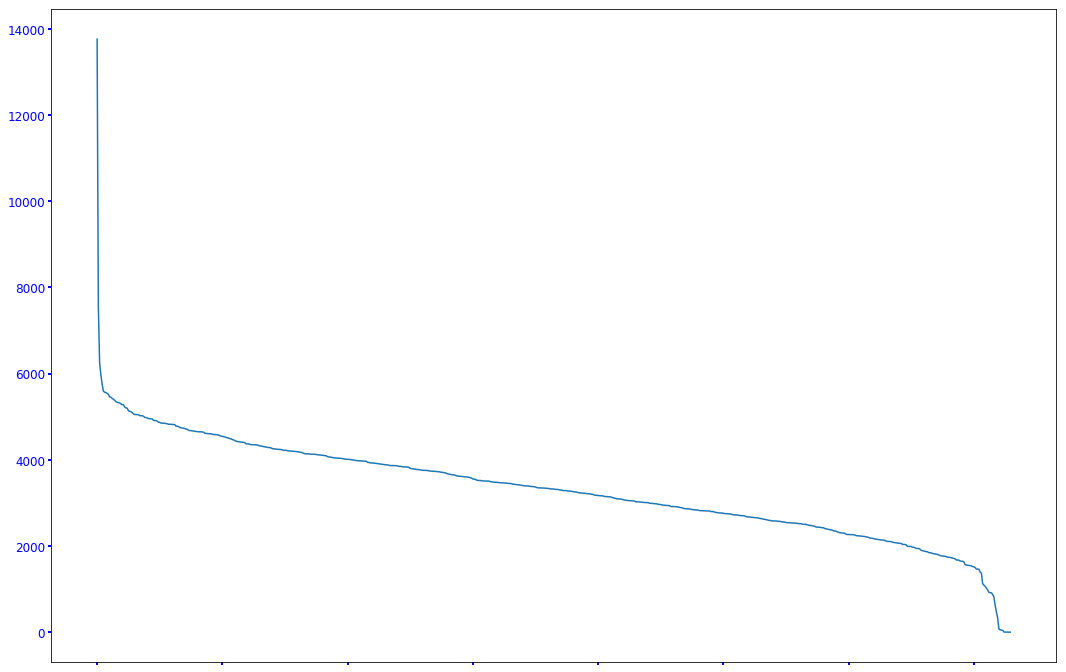

In [31]:
figure, ax = plt.subplots(figsize=(18, 12))
ax.tick_params(direction='out', length=3, width=2, colors='b', grid_color='r', grid_alpha=0.5, labelsize='large')
df_lemmas['_drawer'].value_counts().plot()

Fixing ambiguous information for two typists with same abbreviation:

- Christine Schellhorn (up to drawer 403 – this was her last drawer 
- Sonja Schwaiger (from drawer 636 – this was her first drawer)

In [32]:
df_lemmas[df_lemmas['_typist'] == 'Christine Schellhorn']['_drawer'].unique()

array(['HK 157', 'HK 000', 'HK 165', 'HK 170', 'HK 176', 'HK 188',
       'HK 240', 'HK 225', 'HK 234', 'HK 243', 'HK 255', 'HK 263',
       'HK 270', 'HK 276', 'HK 281', 'HK 290', 'HK 296', 'HK 301',
       'HK 311', 'HK 318', 'HK 324', 'HK 332', 'HK 334', 'HK 339',
       'HK 347', 'HK 353', 'HK 361', 'HK 376', 'HK 383', 'HK 389',
       'HK 403', 'HK 636', 'HK 652', 'HK 665', 'HK 673', 'HK 687',
       'HK 703', 'HK 708', 'HK 724', 'HK 729', 'HK 735', 'HK 739',
       'HK 749', 'HK 755', 'HK 765', 'HK 771', 'HK 780', 'HK 789',
       'HK 795', 'HK 804', 'HK 812', 'HK 821', 'HK 831', 'HK 836',
       'HK 844', 'HK 854', 'HK 856', 'HK 858', 'HK 867', 'HK 870',
       'HK 881'], dtype=object)

In [33]:
drw = df_lemmas[df_lemmas['_typist'] == 'Christine Schellhorn'].index

func = lambda x:int(x[3:])
for idx in drw:
    x = df_lemmas.loc[idx,'_drawer']
    if func(x) > 500:
        df_lemmas.loc[idx]['_typist'] = 'Sonja Schwaiger'

In [34]:
df_lemmas['_typist'].sort_values().value_counts()

Barbara Piringer          375962
Claudia Hareter-Kroiss    253213
Monika Platzer            211855
Bettina Barabas           186280
Lana Mayer                150502
Renate Eckel              132557
Birgit Hofstetter         117544
Sonja Schwaiger           115656
Eva Pudill                102226
Christian Nedoma           93332
Monika Ranftl              92024
Christine Schellhorn       78757
Bettina Fürst              77013
Angelika Eisenhut          72959
Berthold Foeger            69227
Markus Pascher             52137
Sybille Groh               48845
Karin Kupitz               45738
Barbara Konate             34644
Marianne Pühringer         31013
Christine Hager            24985
Tamara Loitfellner         17048
Veronika Gasser            12159
Manfred Lagler             10409
Johanna Grützbauch          7464
Reinhard Bachmaier          2823
Name: _typist, dtype: int64

In [35]:
df_lemmas[['_typist',
           'hauptlemma_normalized',
           'hauptlemma_orig',
           'hauptlemma_unique',
           'nebenlemma_normalized',
           'nebenlemma_orig',
           'nebenlemma_unique',]].groupby(['_typist']).count()

,hauptlemma_normalized,hauptlemma_orig,hauptlemma_unique,nebenlemma_normalized,nebenlemma_orig,nebenlemma_unique
_typist,,,,,,
Angelika Eisenhut,38782,38782,29119,2105,2106,806
Barbara Konate,19996,19997,13225,1386,1386,705
Barbara Piringer,217140,217500,155106,22702,22708,18446
Berthold Foeger,39013,39013,26843,1688,1688,1370
Bettina Barabas,101220,101222,61244,2526,2531,1327
Bettina Fürst,44793,44793,25618,5265,5265,1835
Birgit Hofstetter,63571,63571,46441,9895,9895,5501
Christian Nedoma,51119,51120,39292,5376,5376,3522
Christine Hager,15853,15853,6907,1378,1383,683


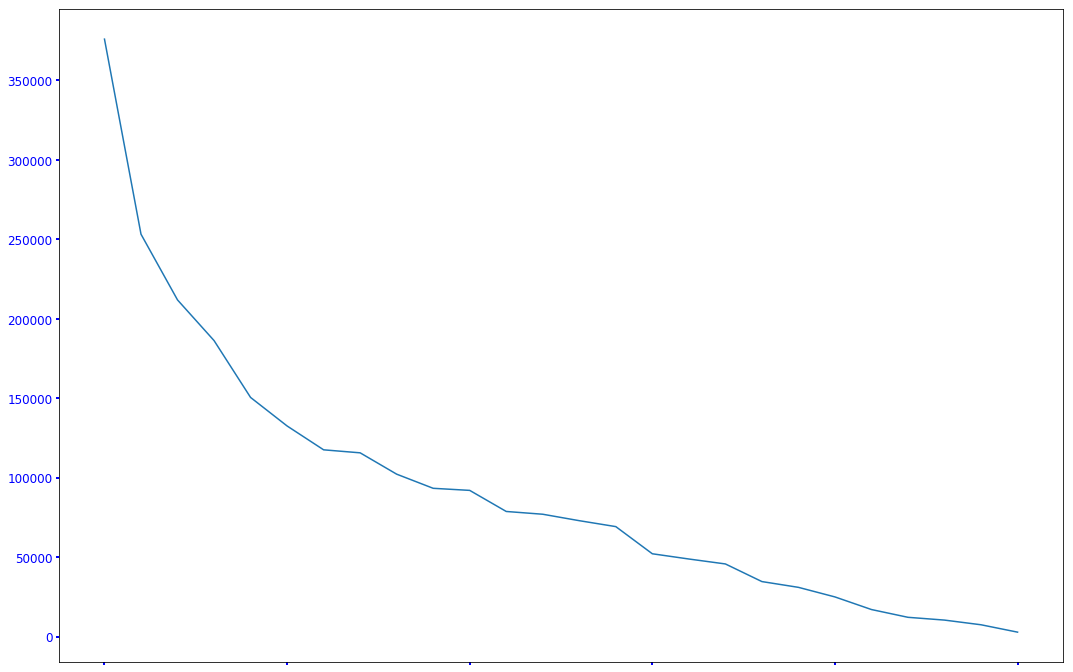

In [36]:
figure, ax = plt.subplots(figsize=(18, 12))
ax.tick_params(direction='out', length=3, width=2, colors='b', grid_color='r', grid_alpha=0.5, labelsize='large')
df_lemmas['_typist'].value_counts().plot()

#### 4) number of headwords per letter

In [37]:
headwords_idx = set(list(df_lemmas.hauptlemma_unique.dropna().index) \
                + list(df_lemmas.hauptlemma_normalized.dropna().index) \
                + list(df_lemmas.hauptlemma_orig.dropna().index) \
                + list(df_lemmas.nebenlemma_unique.dropna().index) \
                + list(df_lemmas.nebenlemma_normalized.dropna().index) \
                + list(df_lemmas.nebenlemma_orig.dropna().index))

In [38]:
headwords_list = []

for idx in headwords_idx:
    if df_lemmas.hauptlemma_unique.iloc[idx]:
        headwords_list.append(df_lemmas.hauptlemma_unique.iloc[idx])
    elif df_lemmas.hauptlemma_normalized.iloc[idx]:
        headwords_list.append(df_lemmas.hauptlemma_normalized.iloc[idx])
    elif df_lemmas.hauptlemma_orig.iloc[idx]:
        headwords_list.append(df_lemmas.hauptlemma_orig.iloc[idx])
    elif df_lemmas.nebenlemma_unique.iloc[idx]:
        headwords_list.append(df_lemmas.nebenlemma_unique.iloc[idx])
    elif df_lemmas.nebenlemma_normalized.iloc[idx]:
        headwords_list.append(df_lemmas.nebenlemma_normalized.iloc[idx])
    elif df_lemmas.nebenlemma_orig.iloc[idx]:
        headwords_list.append(df_lemmas.nebenlemma_orig.iloc[idx])
        
first_letter = [x[0].upper() for x in headwords_list]

In [39]:
freq_letters = nltk.FreqDist(first_letter)

freq_letters.pop('(')
freq_letters.pop(' ')
freq_letters.pop('←')
freq_letters.pop('[')
freq_letters.pop(':')
freq_letters.pop('^')
freq_letters.pop('?')
freq_letters.pop('1')
freq_letters.pop('2')
freq_letters.pop('6')
freq_letters.pop('─')
freq_letters.pop('†')
freq_letters.pop('~')
freq_letters.pop('|')
freq_letters.pop('\xa0')

freq_letters.most_common(50)

[('S', 373210),
 ('G', 192629),
 ('F', 190978),
 ('H', 189854),
 ('K', 180359),
 ('A', 162978),
 ('W', 122670),
 ('M', 107322),
 ('R', 104967),
 ('L', 101267),
 ('P', 90019),
 ('Z', 85329),
 ('T', 74090),
 ('E', 71092),
 ('D', 61183),
 ('N', 54603),
 ('U', 33973),
 ('J', 21494),
 ('O', 21345),
 ('B', 13719),
 ('Ü', 11380),
 ('I', 9663),
 ('Ë', 7563),
 ('Ê', 5051),
 ('Ô', 3280),
 ('Q', 2768),
 ('Ö', 2668),
 ('Â', 1275),
 ('Ä', 1132),
 ('V', 324),
 ('C', 98),
 ('Û', 82),
 ('X', 62),
 ('Y', 34),
 ('Á', 14),
 ('Å', 9),
 ('Ú', 3),
 ('!', 3),
 ('SS', 3),
 ('Ó', 2),
 ('9', 2),
 ('É', 1),
 ('Î', 1),
 ('+', 1),
 ('Ǎ', 1),
 ('Ē', 1),
 ('5', 1),
 ('*', 1),
 ('¹', 1),
 ('Í', 1)]

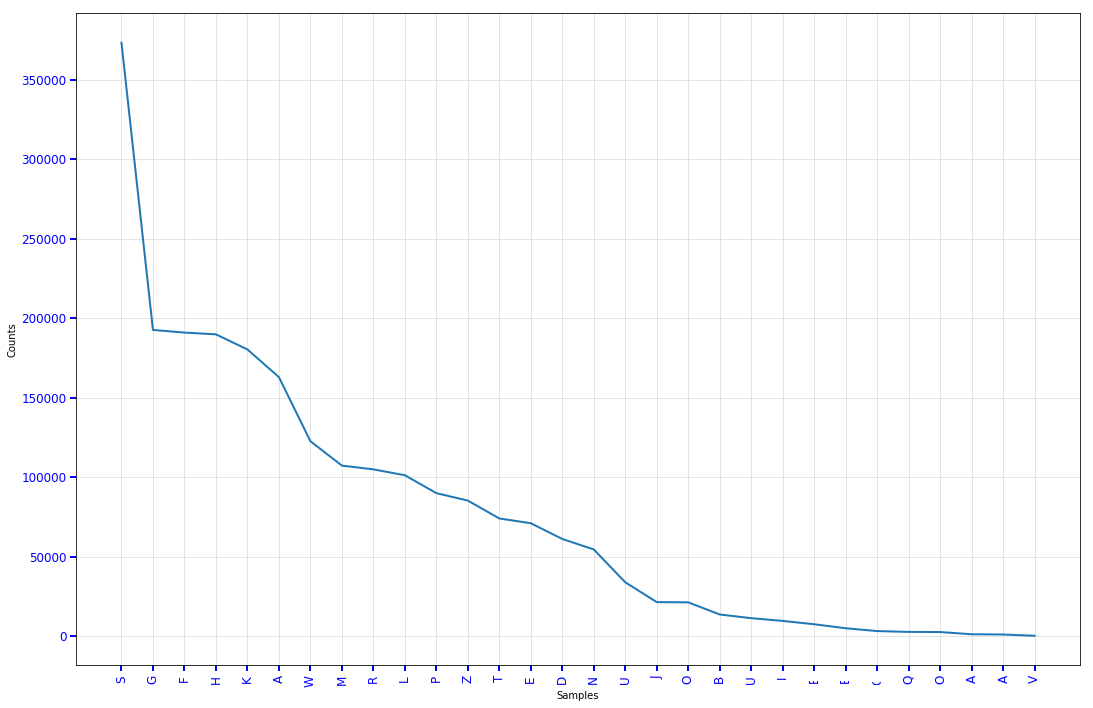

In [40]:
figure, ax = plt.subplots(figsize=(18, 12))
ax.tick_params(direction='out', length=6, width=2, colors='b', grid_color='r', grid_alpha=0.5, labelsize='large')
freq_letters.plot(30,cumulative=False,)

#### 5) number of headwords per location

In [42]:
print(len(set(df_lemmas.Bundesland.dropna().index)))
print(len(set(df_lemmas.Ort.dropna().index)))
print(len(set(df_lemmas.Bundesland.dropna().index).intersection(set(df_lemmas.Ort.dropna().index))))

1316889
1198447
1198447


In [41]:
# there is no intersection between records with simple placenames and records with original placenames
set(df_lemmas.simple_placeName.dropna().index).intersection(set(df_lemmas.orig_placeName.dropna().index))

set()

In [43]:
# and there is no intersection between records with simple placenames and records with Ort information
set(df_lemmas.simple_placeName.dropna().index).intersection(set(df_lemmas.Ort.dropna().index))

set()

In [44]:
locations_idx = set(df_lemmas.simple_placeName.dropna().index)\
.union(set(df_lemmas.Ort.dropna().index))\
.union(df_lemmas.orig_placeName.dropna().index)

In [45]:
locations_list = []

for idx in locations_idx:
    if df_lemmas.simple_placeName.iloc[idx]:
        locations_list.append(df_lemmas.simple_placeName.iloc[idx])
    elif df_lemmas.Ort.iloc[idx]:
        locations_list.append(df_lemmas.Ort.iloc[idx])
    elif df_lemmas.orig_placeName.iloc[idx]:
        locations_list.append(df_lemmas.orig_placeName.iloc[idx])

In [46]:
freq_locations = nltk.FreqDist(locations_list)
freq_locations.most_common(50)

[('Wien', 71263),
 ('Mühlheim am Inn', 34694),
 ('(Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW', 33278),
 ('Gmunden', 33056),
 ('Kautzen', 32858),
 ('Kufstein', 21403),
 ('Linz', 21282),
 ('Plattetschl. BöW', 20835),
 ('Thiersee $Tiersee$', 20598),
 ('Poysdorf', 19641),
 ('Rangersdorf', 16430),
 ('Stainz', 16174),
 ('(Umg./Bz.) Braunau OÖ', 15722),
 ('Traun', 15627),
 ('Dunkelsteinerwald', 15541),
 ('Hohenfurth SBö.', 15374),
 ('Königswerth Egerld.', 14392),
 ('Fusch an der Großglocknerstraße', 13364),
 ('Puchberg am Schneeberg', 12969),
 ('Obermösel in Gm. Mösel Gott.(Slow.)', 12555),
 ('Pottendorf', 12501),
 ('Fendels', 11318),
 ('Kleinlobming', 11088),
 ('Sonnbg. SBö.', 10836),
 ('Straßburg', 10781),
 ('Ulrichsberg', 10609),
 ('Tullnitz SMä.', 10286),
 ('Rohr im Gebirge', 10276),
 ('Herzogenburg', 10084),
 ('Imst', 9854),
 ('Pilgersdorf', 9769),
 ('Gr.Tajax SMä.', 9579),
 ('Kumrowitz Brünn (Tschech.)', 9416),
 ('St. Gilgen', 9103),
 ('Hollabrunn', 8843),
 ('Gr.Arlt. in Sa.', 8769),

#### 6) average number of entries per headword

In [47]:
freq_words = nltk.FreqDist(headwords_list)
freq_words.most_common(50)

[('gên', 9039),
 ('kemmen', 5883),
 ('Hand', 5088),
 ('Haut', 4253),
 ('Kopf', 3931),
 ('Leib', 3790),
 ('Zand', 3671),
 ('sein', 3283),
 ('sehen', 3267),
 ('lich', 3200),
 ('tuon', 3131),
 ('rôt', 2773),
 ('klein', 2636),
 ('halten', 2617),
 ('Hâr', 2573),
 ('Nase', 2375),
 ('schwarz', 2308),
 ('ziehen', 2261),
 ('Hôhzeit', 2230),
 ('haben', 2208),
 ('schlagen', 2190),
 ('faren', 2171),
 ('machen', 2023),
 ('können', 2012),
 ('Mann', 1987),
 ('ein', 1975),
 ('lâßen', 1960),
 ('Maul', 1952),
 ('schwellen', 1945),
 ('guot', 1941),
 ('gëben', 1924),
 ('Georg', 1902),
 ('schön', 1878),
 ('Ort', 1859),
 ('Stein', 1847),
 ('schneiden', 1825),
 ('Fleisch', 1796),
 ('kurz', 1749),
 ('ër', 1736),
 ('Kind', 1732),
 ('helfen', 1687),
 ('Haus', 1685),
 ('schwär', 1683),
 ('Finger', 1672),
 ('ê', 1652),
 ('lang', 1628),
 ('schauen', 1613),
 ('grôß', 1608),
 ('Schneider', 1597),
 ('weiß', 1581)]

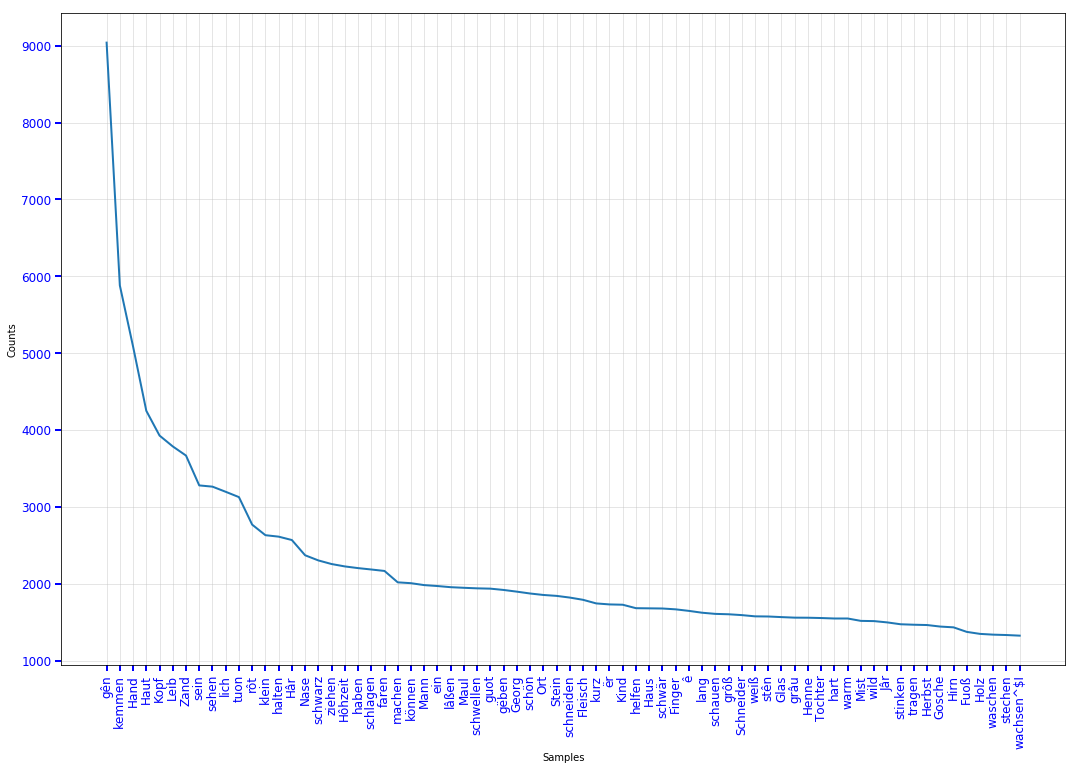

In [48]:
figure, ax = plt.subplots(figsize=(18, 12))
ax.tick_params(direction='out', 
               length=6, 
               width=2, 
               colors='b', 
               grid_color='r', 
               #labelrotation=45,
               grid_alpha=0.5, 
               labelsize='large')

freq_words.plot(70,cumulative=False,)

In [49]:
len(headwords_list)/len(freq_words)

9.61762763716607

#### 7) number of different definitions / meanings

#### 8) number of locations cited

In [50]:
len(freq_locations)

27542

In [51]:
for col in regions_info:
    print(col, '--->', len(df_lemmas[col].unique()))

Bundesland ---> 10
Bundesland_idno ---> 10
Gemeinde ---> 1147
Großregion ---> 33
Großregion_idno ---> 32
Kleinregion ---> 324
Kleinregion_idno ---> 322
Ort ---> 1146
Ort_idno ---> 1147
simple_placeName ---> 25494
orig_placeName ---> 4437
placeName_id ---> 1308
usg_corresp ---> 21


In [52]:
#fine grained locations --> Ort + simple placename + original placename
len(set(df_lemmas.Ort).union(set(df_lemmas.simple_placeName)).union(df_lemmas.orig_placeName))

30231

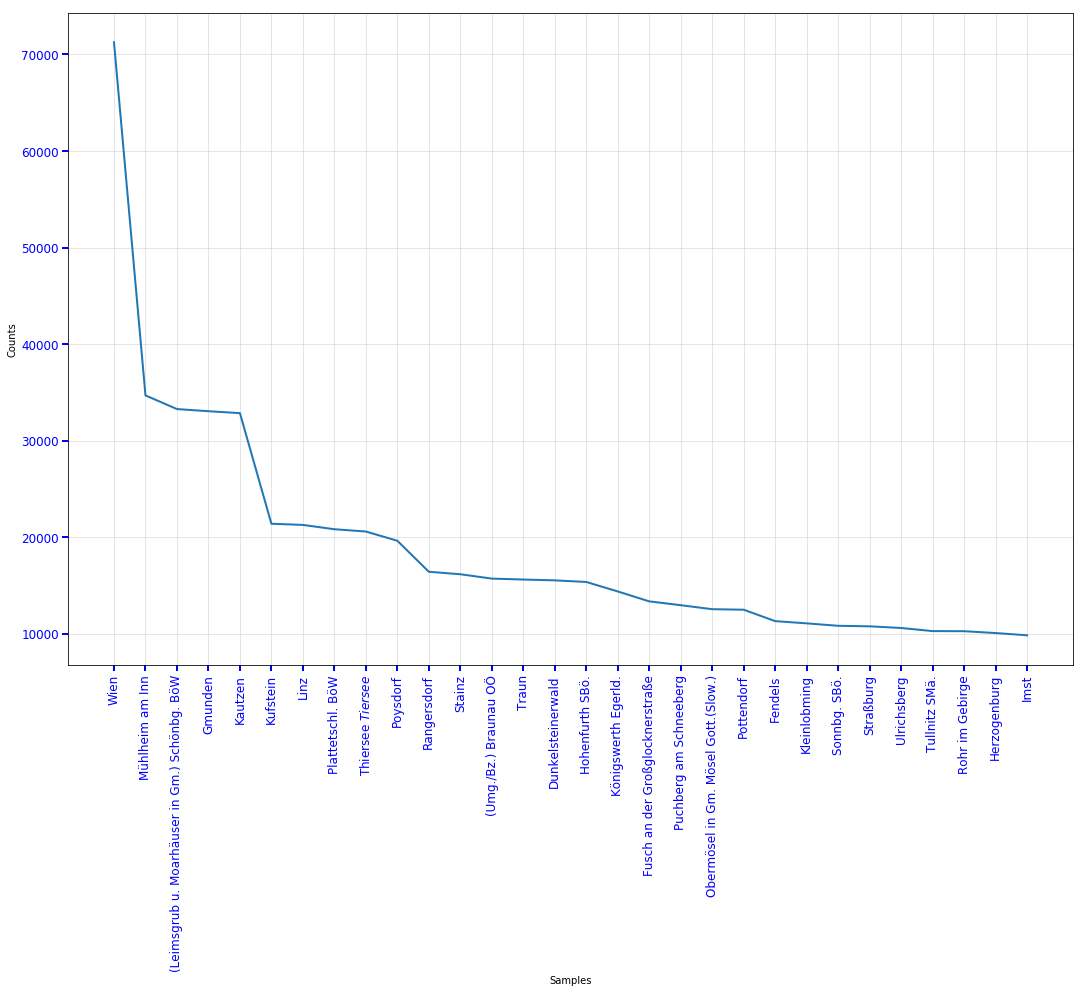

In [53]:
figure, ax = plt.subplots(figsize=(18, 12))
ax.tick_params(direction='out', 
               length=6, 
               width=2, 
               colors='b', 
               grid_color='r', 
               #labelrotation=45,
               grid_alpha=0.5, 
               labelsize='large')

freq_locations.plot(30,cumulative=False,)

#### 9) number of sources cited

#### 10) number of different people cited

#### 11) number of headwords per person

#### 12) number of entries per person

#### 13) number of concepts per questionnaire

#### 14) number of headwords related to questionnaire

In [54]:
df_lemmas.fragebogenNummer.value_counts()

23I6b: Haut m. Adj., Syn. (behaart/Pelz, gelbl.,*); Zshg. Hautfarbe-Haarfarbe/Charakter?                     2707
1A20: Kopf/Schädel als Gw. (Weiberkopf)                                                                      2382
1A3: Kopf/Haupt (übertr.) in Vergl./Ra.                                                                      2286
21C8: Fleisch best.Lebewesen (Heiden-*, Hirsch-,*)                                                           2262
1E12: Backenstreich/Ohrfeige; leicht/stark/schallend                                                         2047
20B2: Blut m. Vb. (es rinnt/hämmert; B. verlieren,*)                                                         2013
43A54b: kommen m. Ziel-/Ortsang. (aus d.Sinn k.,*)                                                           1982
1H1: Mund/Maul; Füg./Ra.                                                                                     1956
42A13d: gehn m. Ziel-/Ortsang. (fortg.; aufs Land g.;*)                                 

In [55]:
idx1 = set(df_lemmas['fragebogenNummer'].dropna()[df_lemmas['fragebogenNummer'].dropna().str.contains("EFb")].index)

In [56]:
len(df_lemmas['fragebogenNummer'][idx1])

156043

In [57]:
idx2 = set(df_lemmas['fragebogenNummer'].dropna()[df_lemmas['fragebogenNummer'].dropna().str.contains("MüWi")].index)

In [58]:
len(df_lemmas['fragebogenNummer'][idx2])

755

In [59]:
idx3 = set(df_lemmas['fragebogenNummer'].dropna().index)

In [60]:
idx3 = idx3 - idx1
idx3 = idx3 - idx2

In [61]:
len(df_lemmas['fragebogenNummer'][idx3])

1140338

In [62]:
df_lemmas['_fragebogen'] = None
df_lemmas.loc[idx1,'_fragebogen'] = 'Additional'
df_lemmas.loc[idx2,'_fragebogen'] = 'Geographic'
df_lemmas.loc[idx3,'_fragebogen'] = 'Systematic'

In [63]:
bestlemma = []
for idx in df_lemmas.index:
    if df_lemmas.hauptlemma_normalized.iloc[idx]:
        bestlemma.append(df_lemmas.hauptlemma_normalized.iloc[idx])
    elif df_lemmas.hauptlemma_unique.iloc[idx]:
        bestlemma.append(df_lemmas.hauptlemma_unique.iloc[idx])
    elif df_lemmas.hauptlemma_orig.iloc[idx]:
        bestlemma.append(df_lemmas.hauptlemma_orig.iloc[idx])
    elif df_lemmas.nebenlemma_normalized.iloc[idx]:
        bestlemma.append(df_lemmas.nebenlemma_normalized.iloc[idx])
    elif df_lemmas.nebenlemma_orig.iloc[idx]:
        bestlemma.append(df_lemmas.nebenlemma_orig.iloc[idx])
    elif df_lemmas.nebenlemma_unique.iloc[idx]:
        bestlemma.append(df_lemmas.nebenlemma_unique.iloc[idx])
    else:
        bestlemma.append(None)

        
df_lemmas['_bestlemma'] = bestlemma
del(bestlemma)

In [64]:
print('Systematic: ', df_lemmas[df_lemmas['_fragebogen'] == 'Systematic']['_bestlemma'].value_counts().count())
print('Additional: ', df_lemmas[df_lemmas['_fragebogen'] == 'Additional']['_bestlemma'].value_counts().count())
print('Geographic: ', df_lemmas[df_lemmas['_fragebogen'] == 'Geographic']['_bestlemma'].value_counts().count())

Systematic:  118269
Additional:  7849
Geographic:  447


#### 15) number of headwords related to questions

#### 16) number of entries related to questions related to authors of questions/questionnaires

#### 17) number of headwords related to questions related to authors of questions/questionnaires

#### 18) number of locations per person (that is identified)

#### 19) number of female:male collectors

#### 20) average number of entries per questions

#### 21) number of entries related to questionnaires

In [ ]:
df_lemmas['_fragebogen'].value_counts()

#### 22) number of entries related to historical sources

#### 23) number of entries related to historical poetic sources

#### 24) number of entries related to "free collections"

#### 25) number of people working on the collection since the start

#### 26) names of people working on the collection since the start

#### 27) number of collectors per questionnaire

#### 28) average number of definitions per entry / paper slip

#### 29) average number of entries per person

#### 30) average number of headwords per person

#### 31) average number of entries per type of location

#### 32) average number of headwords per type of location

#### 34) persons sorted by the number of headwords (and a list of those headwords) that are least frequent in the corpus

#### 35) headwords sorted by frequency

#### 36) headwords sorted by frequency related to certain types of regions (e.g AT., bundesland, smallest regional unit, municipality)

#### 37) number of entries with time information

In [ ]:
for year in df_lemmas.date.unique():
    print(year)

In [ ]:
df_lemmas.date.value_counts()

Substituting references to centuries with the middle of the century (e.g. 16.Jh. ---> 1650)

In [ ]:
string1 = 
print(re.sub(r"(\d.*?)\s(\d.*?)", r"\1 \2", string1))

#data["Team"]= data["Team"].str.replace("boston", "New Boston", case = False) 
#df_lemmas[df_lemmas['_typist'].isna()]['archiv'].value_counts()

In [ ]:
re.sub(r'def\s+([a-zA-Z_][a-zA-Z_0-9]*)\s*\(\s*\):', r'static PyObject*\npy_\1(void)\n{', 'def myfunc():')
#'static PyObject*\npy_myfunc(void)\n{'

In [ ]:
df_lemmas['_year'] = df_lemmas['date'].str.extract('([0-9]{4})', expand=True)
df_lemmas['_year'].sort_values().value_counts()

In [108]:
df_lemmas['_year'] = df_lemmas['date'].str.extract('(1[0-9]{1}[\s.]+[JjHh.]{2,})', expand=True)
df_lemmas['_year'].sort_values().value_counts()

16.Jh.     1051
16. Jh.     794
17.Jh.      783
15.Jh.      645
17. Jh.     521
15. Jh.     422
18.Jh.      266
17.jh.      239
16. jh.     224
16.jh.      210
17. jh.     202
18. Jh.     199
15. jh.     169
15.jh.      153
14.Jh.      105
14. Jh.     102
16.Jh        78
18.jh.       62
16. Jh       58
15.Jh        56
18. jh.      49
17.Jh        48
15. Jh       44
17. Jh       39
14. Jh       31
18.Jh        25
14.Jh        25
18. Jh       24
16 Jh.       18
17 Jh.       16
           ... 
11.Jh.        2
17.JH.        2
15.jh         2
12. Jh.       2
18.jh         2
18 Jh.        2
17.jh         2
13.Jh         2
17 Jh         2
15. jh        2
14 Jh.        2
19.Jh         2
11. Jh.       1
13.jh.        1
14. Hh        1
16.jh         1
18 Jh         1
10 Jh.        1
12 Jh         1
14. jh        1
12.Jh         1
18 JH         1
15 .Jh.       1
16 jh.        1
10.Jh.        1
16. JH.       1
18. jh        1
13. Jh        1
18 jh         1
19.jh.        1
Name: #year, Length: 78,

In [65]:
df_lemmas[df_lemmas['#year'].isna()]['date'].value_counts()

17.Jh.                     738
16.Jh.                     707
15.Jh.                     567
16. Jh.                    498
17. Jh.                    486
15. Jh.                    377
17.jh.                     237
16. jh.                    214
17. jh.                    201
16.jh.                     195
15. jh.                    166
15.jh.                     152
18.Jh.                     152
18. Jh.                    106
Mitte 16.Jh.                98
14.Jh.                      94
14. Jh.                     90
Mitte 16. Jh.               87
18.jh.                      56
2.Hä.16.Jh.                 47
18. jh.                     42
2. Hälfte 16. Jh.           41
16.Jhdt.                    41
1. Hä. 16. Jh.              37
1. Hälfte 18. Jh.           36
1.Hä.16.Jh.                 33
2. Hä. 16. Jh.              29
2. H. 16. Jh.               27
Mitte 18.Jh.                27
\n                          26
                          ... 
vor Jahren                   1
1 Dezen.

In [78]:
df_lemmas['date'].str.extract('(1[0-9]{1}[\s.]+[JjHh.]{2,})', expand=True)[0].unique()

array([nan, '16.Jh.', '17.Jh.', '15.Jh.', '18.Jh.', '16. jh.', '18. jh.',
       '17. jh.', '13. Jh.', '15. jh.', '16. Jh.', '17.jh.', '16.jh.',
       '14. Jh.', '14.Jh', '13.Jh.', '15.jh.', '15. Jh.', '14.Jh.',
       '15. Jh', '17. Jh.', '18. Jh', '14. jh.', '18. Jh.', '15.Jh',
       '18.Jh', '16.Jh', '17 jh.', '18.jh.', '17.Jh', '14.jh.', '18 jh.',
       '16. Jh', '19.Jh.', '12.Jh.', '19.jh.', '17 Jh.', '14. Jh',
       '16 Jh', '17. Jh', '15 Jh', '17.JH.', '16 Jh.', '11.Jh.', '18 Jh.',
       '18 JH', '18 Jh', '19. Jh.', '15 Jh.', '16. JH.', '14. Hh',
       '17.jh', '15. jh', '19.Jh', '18.jh', '12 Jh', '15 jh.', '13.Jh',
       '10 Jh.', '12. Jh.', '10. Jh.', '19. Jh', '16 jh.', '13.jh.',
       '15.jh', '12.Jh', '10.Jh.', '15 jh', '16. jh', '17 jh', '14. jh',
       '18 jh', '17 Jh', '14 Jh.', '18. jh', '13. Jh', '15 .Jh.', '16.jh',
       '11. Jh.'], dtype=object)

#### 38) average number of entries per collection

#### 39) percentage of headwords in a certain location per person

#### 40) percentage of plant names per letter  

In [29]:
len(df_lemmas) - len(locations_idx)

686299

#### Exporting the Enriched Dataframe

In [30]:
df_lemmas.to_pickle('./df_lemmas.pkl')

#### Building a SQLite Database

In [31]:
conn = sqlite3.connect('./lemmas_db.sqlite')

In [32]:
df_lemmas.applymap(str).head()

,Bundesland,Bundesland_idno,Gemeinde,Großregion,Großregion_idno,Kleinregion,Kleinregion_idno,Ort,Ort_idno,archiv,...,seite,simple_placeName,tustep,usg_corresp,verweise,#form,#drawer,#fragebogen,#bestlemma,#typist
0,None,None,None,None,None,None,None,None,None,"HK 154, d154^#1.1 = d1540308.pir^#1.1",...,30,None,"('diaun',)",None,None,HK 154,HK 154,None,Diaun,Barbara Piringer
1,None,None,None,None,None,None,None,None,None,"HK 154, d154^#2.1 = d1540308.pir^#2.1",...,601,Chur,"('diaun',)",None,None,HK 154,HK 154,None,Diaun,Barbara Piringer
2,None,None,None,None,None,None,None,None,None,"HK 154, d154^#3.1 = d1540308.pir^#3.1",...,"1,1293,337, f337^#3.4 = f.",Chur,"('diaun',)",None,None,HK 154,HK 154,None,Diaun,Barbara Piringer
3,None,None,None,None,None,None,None,None,None,"HK 154, d154^#4.1 = d1540308.pir^#4.1",...,None,None,"('tib',)",None,None,HK 154,HK 154,Systematic,tib,Barbara Piringer
4,None,None,None,None,None,None,None,None,None,"HK 154, d154^#5.1 = d1540308.pir^#5.1",...,None,None,"('tib',)",None,None,HK 154,HK 154,Systematic,tib,Barbara Piringer


In [33]:
df_lemmas.applymap(str).to_sql(name='lemmas', con=conn)

In [34]:
cur = conn.cursor()

In [35]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('lemmas',)]


In [52]:
q = '''
select /#typist from lemmas limit 10;
'''

In [53]:
#form, #typist, #drawer, #fragebogen, #bestlemma

In [54]:
cur.execute(q)
print(cur.fetchall())

OperationalError: near "/": syntax error

In [ ]:
conn.close()